# DeepLabCut Speed Calculation

A Jupyter notebook to load DeepLabCut CSV output and calculate mouse speed based on tracked body parts.

## Setup Environment and Variables

Import necessary libraries (pandas, numpy). Define variables for the input directory (`input_dir`), DLC output filename (`file_name`), desired likelihood threshold (`likelihood_threshold`), and video frame rate (`frame_rate` in frames per second).

In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import linregress
%matplotlib widget
%load_ext autoreload
%autoreload 2
from plotting_utils import *
from debugging_functions import *


# --- User Defined Variables ---

# Directory containing the DLC output CSV file
input_dir = r'C:\Users\Experiment\Projects\video_conversions\full'

# Name of the DLC CSV file (output from DLC analysis)
file_name = 'fullDLC_resnet50_downsampled_trialJul11shuffle1_150000.csv' 

video_filename = file_name.split('DLC_resnet')[0] + 'DLC_resnet50_downsampled_trialJul11shuffle1_150000_labeled.mp4'
# Likelihood threshold - points below this threshold will be considered unreliable
likelihood_threshold = 0.95

# Frame rate of the video in frames per second (FPS)
frame_rate = 60

DEFAULT_BODYPARTS = [
    'neck', 'mid_back', 'mouse_center', 'mid_backend', 'left_midside', 
    'right_midside', 'right_hip', 'left_ear', 'right_ear', 'left_ear_tip', 'right_ear_tip',
    'left_shoulder', 'right_shoulder', 'head_midpoint'
]
# Body parts to use for speed calculation.
# Provide a list of bodypart names, e.g., ['nose', 'mouse_center', 'tail_base'].
# If the list is empty or None, all bodyparts found in the file will be used.
bodyparts_for_calculation = [] # 'mouse_center', 'mid_back', 'neck'


# Construct the full file path
file_path = os.path.join(input_dir, file_name)

video_file_path = os.path.join(input_dir, video_filename)
if not os.path.exists(video_file_path):
    print(f"Warning: Video file not found at {video_file_path}. Video generation will be skipped.")
    create_synced_video = False
else:
    create_synced_video = True # Set to False to skip video generation
    print(f"Video file found: {video_file_path}")

print(f"Input Directory: {input_dir}")
print(f"File Name: {file_name}")
print(f"Full File Path: {file_path}")
print(f"Likelihood Threshold: {likelihood_threshold}")
print(f"Frame Rate (FPS): {frame_rate}")
print(f"Bodyparts for Speed Calculation: {'Default List' if not bodyparts_for_calculation else ('All' if bodyparts_for_calculation == ['all'] else bodyparts_for_calculation)}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Video file found: C:\Users\Experiment\Projects\video_conversions\full\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_labeled.mp4
Input Directory: C:\Users\Experiment\Projects\video_conversions\full
File Name: fullDLC_resnet50_downsampled_trialJul11shuffle1_150000.csv
Full File Path: C:\Users\Experiment\Projects\video_conversions\full\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000.csv
Likelihood Threshold: 0.95
Frame Rate (FPS): 60
Bodyparts for Speed Calculation: Default List


## Load DLC Data

Read the specified CSV file using pandas. Handle the multi-level header correctly (scorer, bodyparts, coords) by specifying the header rows. Display the first few rows and the structure (columns) of the loaded DataFrame.

In [2]:
# Check if the file exists before attempting to load
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Error: The file was not found at the specified path: {file_path}")

# Load the CSV file, specifying the header rows
# DLC CSV files typically have a multi-level header:
# Row 0: Scorer
# Row 1: Bodyparts
# Row 2: Coordinates (x, y, likelihood)
try:
    df_dlc = pd.read_csv(file_path, header=[1, 2], index_col=0)
    print("DLC data loaded successfully.")
except Exception as e:
    print(f"Error loading CSV file: {e}")
    raise

# Display the first few rows
print("\nFirst 5 rows of the loaded data:")
print(df_dlc.head())

# Display the column structure (multi-index)
print("\nDataFrame Columns:")
print(df_dlc.columns)

# Display basic info
print("\nDataFrame Info:")
df_dlc.info()

DLC data loaded successfully.

First 5 rows of the loaded data:
bodyparts        nose                           left_ear               
coords              x           y likelihood           x           y   
0          129.560760  402.219238   0.082020  125.590157  428.051331  \
1          129.439468  402.191986   0.103668  125.987770  428.301971   
2          128.443726  402.066254   0.128062  125.967255  428.305847   
3          180.338257  461.936218   0.214641  126.092499  428.263580   
4          128.178284  402.274353   0.162708  126.445503  428.542267   

bodyparts              right_ear                        left_ear_tip  ...   
coords    likelihood           x           y likelihood            x  ...   
0           0.999963  144.542648  416.686310   0.999965   125.109055  ...  \
1           0.999970  145.142487  416.333038   0.999968   125.123558  ...   
2           0.999961  145.624374  416.984802   0.999956   124.321877  ...   
3           0.999942  146.140060  416.582764  

## Define Speed Calculation Strategy

Describe the chosen strategy for speed calculation.

**Chosen Strategy (Median-Based):**
1.  Identify the body parts to use for calculation based on the `bodyparts_for_calculation` list. If the list is empty, use the `DEFAULT_BODYPARTS`. If `['all']` is specified, use all available body parts.
2.  For each frame:

    a.  Filter the coordinates (x, y) of each selected body part: if the likelihood for that body part in that frame is below `likelihood_threshold`, its coordinates for that frame are considered NaN.
    
    b.  Calculate the **median x-coordinate** and **median y-coordinate** from all *valid* (non-NaN) selected body parts for that frame. This defines a single "median point" for the animal. If too few parts are valid to calculate a median (e.g., all are NaN), the median point's coordinates will be NaN.
3.  Calculate the frame-to-frame displacement (Euclidean distance) of this "median point".
4.  Convert this displacement (pixels/frame) into speed (pixels/second) using the `frame_rate`.
5.  The speed for the very first frame will be NaN. Speed will also be NaN for transitions where the median point in either the current or preceding frame could not be determined (was NaN).

## Select and Filter Tracking Points

Select the x, y, and likelihood columns for the body part(s) chosen in the strategy. Apply the `likelihood_threshold`: set x, y coordinates to NaN for frames where the likelihood of the chosen point(s) is below the threshold.

In [3]:
all_bodyparts = df_dlc.columns.get_level_values(0).unique().tolist()
print(f"\nAvailable bodyparts in file: {all_bodyparts}")

final_bodyparts_list = []
missing_parts = []
calculation_mode = None # To store how the list was derived ('all', 'default', 'custom')

if bodyparts_for_calculation == ['all']:
    final_bodyparts_list = all_bodyparts
    calculation_mode = 'all'
    print("\nUsing all available bodyparts for calculation.")
elif not bodyparts_for_calculation: # Empty list means use default
    requested_parts = DEFAULT_BODYPARTS
    calculation_mode = 'default'
    print(f"\nAttempting to use Default bodyparts list: {requested_parts}")
    # Validate default parts against available parts
    for bp in requested_parts:
        if bp in all_bodyparts:
            final_bodyparts_list.append(bp)
        else:
            missing_parts.append(bp)
    if missing_parts:
        print(f"Warning: The following Default bodyparts were not found in the file and will be ignored: {missing_parts}")
else: # Custom list provided
    requested_parts = bodyparts_for_calculation
    calculation_mode = 'custom'
    print(f"\nAttempting to use Custom bodyparts list: {requested_parts}")
    # Validate custom parts against available parts
    for bp in requested_parts:
        if bp in all_bodyparts:
            final_bodyparts_list.append(bp)
        else:
            missing_parts.append(bp)
    if missing_parts:
        print(f"Warning: The following Custom bodyparts were not found in the file and will be ignored: {missing_parts}")

# Final check and report
if not final_bodyparts_list:
    raise ValueError("Error: No valid bodyparts selected for calculation based on input and file contents.")

print(f"\nFinal list of bodyparts used for calculation ({calculation_mode} mode): {final_bodyparts_list}")



Available bodyparts in file: ['nose', 'left_ear', 'right_ear', 'left_ear_tip', 'right_ear_tip', 'left_eye', 'right_eye', 'neck', 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'mid_backend3', 'tail_base', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'left_shoulder', 'left_midside', 'left_hip', 'right_shoulder', 'right_midside', 'right_hip', 'tail_end', 'head_midpoint']

Attempting to use Default bodyparts list: ['neck', 'mid_back', 'mouse_center', 'mid_backend', 'left_midside', 'right_midside', 'right_hip', 'left_ear', 'right_ear', 'left_ear_tip', 'right_ear_tip', 'left_shoulder', 'right_shoulder', 'head_midpoint']

Final list of bodyparts used for calculation (default mode): ['neck', 'mid_back', 'mouse_center', 'mid_backend', 'left_midside', 'right_midside', 'right_hip', 'left_ear', 'right_ear', 'left_ear_tip', 'right_ear_tip', 'left_shoulder', 'right_shoulder', 'head_midpoint']


## Calculate Frame-by-Frame Displacement

Calculate the difference in x and y coordinates between consecutive frames for the filtered tracking point(s). Use the Euclidean distance formula: `sqrt(delta_x^2 + delta_y^2)` to find the displacement in pixels per frame. Handle potential NaN values introduced by filtering or inherent in the data.

In [4]:
# --- Calculate Displacement Per Bodypart with Likelihood Check & Interpolation ---
df_dlc[('analysis', 'median_x')] = np.nan
df_dlc[('analysis', 'median_y')] = np.nan

# Store filtered and interpolated coordinates temporarily to calculate medians
filtered_x_coords = pd.DataFrame(index=df_dlc.index)
filtered_y_coords = pd.DataFrame(index=df_dlc.index)

MAX_CONSECUTIVE_NAN_INTERPOLATE = 60 # Define the number of consecutive frames that can be NaN and still be interpolated

print(f"\nApplying likelihood filter and conditional interpolation (max_gap={MAX_CONSECUTIVE_NAN_INTERPOLATE} frames) to selected bodyparts...")
for bp in final_bodyparts_list:
    if (bp, 'x') not in df_dlc.columns or \
       (bp, 'y') not in df_dlc.columns or \
       (bp, 'likelihood') not in df_dlc.columns:
        print(f"Warning: Data for bodypart {bp} (x, y, or likelihood) not found. Skipping.")
        filtered_x_coords[bp] = np.nan # Fill with NaNs to maintain DataFrame structure
        filtered_y_coords[bp] = np.nan
        continue

    x = df_dlc[(bp, 'x')].copy() # Use .copy() to avoid SettingWithCopyWarning
    y = df_dlc[(bp, 'y')].copy()
    likelihood = df_dlc[(bp, 'likelihood')]
    
    # Apply likelihood threshold: set x, y to NaN where likelihood is low
    mask = likelihood < likelihood_threshold
    x[mask] = np.nan
    y[mask] = np.nan
    
    # Apply conditional interpolation
    x_processed = interpolate_gaps_conditionally(x, MAX_CONSECUTIVE_NAN_INTERPOLATE)
    y_processed = interpolate_gaps_conditionally(y, MAX_CONSECUTIVE_NAN_INTERPOLATE)
    
    filtered_x_coords[bp] = x_processed
    filtered_y_coords[bp] = y_processed

print("\nCalculating median X and Y coordinates per frame from processed data...")
# Calculate median across the filtered and interpolated coordinates for each frame (row-wise)
df_dlc[('analysis', 'median_x')] = filtered_x_coords.median(axis=1, skipna=True)
df_dlc[('analysis', 'median_y')] = filtered_y_coords.median(axis=1, skipna=True)

print("Median coordinates calculated. First 5 rows of median:")
print(df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y')]].head())

# --- Calculate Displacement of the Median Point ---
print("\nCalculating displacement of the (potentially interpolated) median point...")
median_x_coords = df_dlc[('analysis', 'median_x')]
median_y_coords = df_dlc[('analysis', 'median_y')]

# Calculate difference between consecutive frames for the median point
delta_median_x = median_x_coords.diff()
delta_median_y = median_y_coords.diff()

# Calculate Euclidean distance for the median point's displacement
# NaNs will propagate if median_x/y was NaN or if the previous frame's median_x/y was NaN
displacement_median_pixels = np.sqrt(delta_median_x**2 + delta_median_y**2)

# Store the displacement of the median point
df_dlc[('analysis', 'displacement_median_pixels')] = displacement_median_pixels

print("Displacement of median point calculated. First 5 rows of displacement:")
print(df_dlc[('analysis', 'displacement_median_pixels')].head())

print("\nNaN counts for processed median coordinates and their displacement:")
print(f"Median X NaNs: {df_dlc[('analysis', 'median_x')].isna().sum()}")
print(f"Median Y NaNs: {df_dlc[('analysis', 'median_y')].isna().sum()}")
print(f"Displacement of Median NaNs: {df_dlc[('analysis', 'displacement_median_pixels')].isna().sum()}")


Applying likelihood filter and conditional interpolation (max_gap=60 frames) to selected bodyparts...

Calculating median X and Y coordinates per frame from processed data...
Median coordinates calculated. First 5 rows of median:
bodyparts    analysis            
coords       median_x    median_y
0          142.427238  432.554749
1          142.349670  432.284225
2          142.591110  430.954773
3          142.695908  431.192993
4          142.980728  431.182755

Calculating displacement of the (potentially interpolated) median point...
Displacement of median point calculated. First 5 rows of displacement:
0         NaN
1    0.281424
2    1.351198
3    0.260252
4    0.285005
Name: (analysis, displacement_median_pixels), dtype: float64

NaN counts for processed median coordinates and their displacement:
Median X NaNs: 0
Median Y NaNs: 0
Displacement of Median NaNs: 1


## Calculate Speed

Convert the displacement (pixels/frame) into speed (e.g., pixels/second). Use the `frame_rate` variable.

Speed = Displacement / Time per Frame
Time per Frame = 1 / `frame_rate`
Speed = Displacement / (1 / `frame_rate`) = Displacement * `frame_rate`

Store the calculated speed in a new column in the DataFrame. Handle the first frame (which has no preceding frame for displacement calculation) and frames where displacement is NaN.

In [5]:
create_plots = True # Set to False to skip plotting
plot_individual_parts = True # Set to False to plot only average speed
save_plots = True
smoothing_window_seconds = 15/60 # Smoothing window in s. Set to 0 for no smoothing.


Main DataFrame with Median-Derived Speed columns added:
bodyparts    analysis                                          
coords       median_x    median_y displacement_median_pixels   
0          142.427238  432.554749                        NaN  \
1          142.349670  432.284225                   0.281424   
2          142.591110  430.954773                   1.351198   
3          142.695908  431.192993                   0.260252   
4          142.980728  431.182755                   0.285005   

bodyparts                          
coords    speed_pixels_per_second  
0                             NaN  
1                       16.885447  
2                       81.071905  
3                       15.615149  
4                       17.100272  

Speed Summary Statistics (pixels/second) - Median Based:
count    144499.000000
mean         27.264688
std          41.363934
min           0.027890
25%           5.840574
50%          12.430614
75%          32.637818
max        1629.878479


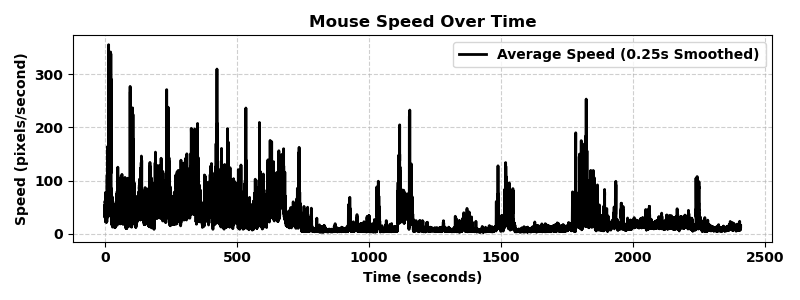

In [6]:
# --- Calculate Average Displacement and Speed ---

time_per_frame = 1.0 / frame_rate # seconds per frame

# Calculate speed in pixels per second
# Speed = Displacement of Median Point (pixels/frame) * Frame Rate (frames/second)
speed_pixels_per_second = df_dlc[('analysis', 'displacement_median_pixels')] * frame_rate

# --- Add results to the main DataFrame ---
# Remove the old 'average_displacement_pixels' column if it exists to avoid confusion
if ('analysis', 'average_displacement_pixels') in df_dlc.columns:
    df_dlc = df_dlc.drop(columns=[('analysis', 'average_displacement_pixels')])

df_dlc[('analysis', 'speed_pixels_per_second')] = speed_pixels_per_second

# Sort columns for potentially better readability (optional)
df_dlc = df_dlc.sort_index(axis=1)

print("\nMain DataFrame with Median-Derived Speed columns added:")
# Display head focusing on new columns
if all(col in df_dlc.columns for col in [('analysis', 'median_x'), ('analysis', 'median_y'), ('analysis', 'displacement_median_pixels'), ('analysis', 'speed_pixels_per_second')]):
    print(df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y'), ('analysis', 'displacement_median_pixels'), ('analysis', 'speed_pixels_per_second')]].head())
else:
    print(df_dlc.head())


# Display summary statistics for the calculated speed
print("\nSpeed Summary Statistics (pixels/second) - Median Based:")
# Check if the speed column exists before describing
if ('analysis', 'speed_pixels_per_second') in df_dlc.columns:
    print(df_dlc[('analysis', 'speed_pixels_per_second')].describe())
else:
    print("Speed column ('analysis', 'speed_pixels_per_second') not found.")

# --- Save the DataFrame with the speed column ---

# Define the subdirectory name
output_subdir = "speed_calculation"
# Create the full path for the output directory
output_dir_path = os.path.join(input_dir, output_subdir)

# Create the subdirectory if it doesn't exist
os.makedirs(output_dir_path, exist_ok=True)
print(f"\nEnsured output directory exists: {output_dir_path}")

base_name_without_ext = os.path.splitext(file_name)[0]
# Add '_all' suffix if the initial bodyparts_for_calculation list was empty
if calculation_mode == 'all':
    suffix = '_all_avg_speed'
elif calculation_mode == 'default':
    suffix = '_default_avg_speed'
elif calculation_mode == 'custom':
    if not final_bodyparts_list: # Should not happen due to check above, but safe
         print("Warning: Custom mode selected but final_bodyparts_list is empty.")
    elif len(final_bodyparts_list) == 1:
        parts_suffix = final_bodyparts_list[0]
        suffix = f'_{parts_suffix}_avg_speed'
    elif len(final_bodyparts_list) == 2:
        parts_suffix = '_'.join(final_bodyparts_list)
        suffix = f'_{parts_suffix}_avg_speed'
    else: # 3 or more parts
        parts_suffix = '_'.join(final_bodyparts_list[:2]) + '_etc'
        suffix = f'_{parts_suffix}_avg_speed'
else:
     print(f"Warning: Unknown calculation_mode '{calculation_mode}'. Using fallback suffix.")
# --- End suffix generation ---

base_output_name = base_name_without_ext + suffix
output_filename_csv = os.path.join(output_dir_path, base_output_name + '.csv')


# Save the DataFrame
try:
    df_dlc.to_csv(output_filename_csv)
    print(f"DataFrame with median-derived speed saved to: {output_filename_csv}")
except Exception as e:
    print(f"Error saving CSV file: {e}")

if create_plots:
    # Since df_displacements (for individual parts) is no longer calculated in the previous cell,
    # we pass an empty DataFrame for it. The plot_speed function's 'Average Speed'
    # will use the new median-derived speed_pixels_per_second from df_dlc.
    # Set plot_individual=False as individual part displacements are not available here.
    empty_df_displacements = pd.DataFrame(index=df_dlc.index)

    plot_speed(df_dlc=df_dlc,
               df_displacements=empty_df_displacements, # Pass empty df
               final_bodyparts_list=final_bodyparts_list, # Still useful for context
               frame_rate=frame_rate,
               output_dir=output_dir_path,
               base_filename=base_output_name,
               plot_individual=False, # Set to False as individual displacements are not passed
               save_plot=save_plots,
               smoothing_window_seconds=smoothing_window_seconds)
else:
    print("\nPlotting is disabled (create_plots=False).")

## Create Video with running graph underneath

Note: this is without the sleep data, for that, see below


In [7]:
# --- Cell for Creating Synchronized Video ---

# Only run if video file was found and create_synced_video is True
if create_synced_video and 'df_dlc' in locals() and ('analysis', 'speed_pixels_per_second') in df_dlc.columns:
    print("\n--- Starting Synchronized Video Generation ---")

   

    # Define output video path
    video_output_filename = base_output_name + '_synced_video.mp4'
    output_video_path = os.path.join(output_dir_path, video_output_filename)

    # --- Prepare Smoothed Speed Data ---
    # Calculate smoothing window in frames
    if smoothing_window_seconds > 0:
        smoothing_window_frames = int(smoothing_window_seconds * frame_rate)
        if smoothing_window_frames < 1:
            smoothing_window_frames = 1
        print(f"Calculating smoothed speed with window: {smoothing_window_frames} frames ({smoothing_window_seconds}s)")
        # Use rolling average on the speed column
        # center=False aligns the window to the right (causal smoothing)
        # min_periods=1 ensures output even at the beginning
        smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')].rolling(window=smoothing_window_frames, min_periods=1, center=False).mean()
    else:
        # ...
        smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')]
        # ...

    # --- Prepare Median Coordinates for Overlay ---
    median_coords_for_video = None
    if ('analysis', 'median_x') in df_dlc.columns and \
       ('analysis', 'median_y') in df_dlc.columns:
        median_coords_for_video = df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y')]]
    else:
        print("Warning: Median coordinate columns not found in df_dlc. Median point overlay will be skipped.")


    # Call the video creation function
    create_synced_video_with_plot(
        video_path=video_file_path,
        speed_data=smoothed_speed,
        frame_rate=frame_rate,
        output_video_path=output_video_path,
        median_coords=df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y')]], # Pass the median coordinates
        plot_width_seconds=5.0,
        plot_height_pixels=200,
        median_point_radius=5, 
        median_point_color=(255,0,0) 
    )
  
elif not create_synced_video:
    print("\nSkipping synchronized video generation because 'create_synced_video' is False or video file was not found.")
else:
    print("\nSkipping synchronized video generation: Prerequisite data ('df_dlc' or speed column) not available.")



--- Starting Synchronized Video Generation ---
Calculating smoothed speed with window: 15 frames (0.25s)
Starting synchronized video creation with median point overlay: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_synced_video.mp4
Original matplotlib backend: module://ipympl.backend_nbagg
Temporarily switched matplotlib backend to: Agg
Median coordinates provided for overlay.
Writing final video to C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_synced_video.mp4...
Moviepy - Building video C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_synced_video.mp4.
Moviepy - Writing video C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_d

t:   0%|          | 44/144500 [00:01<57:13, 42.07it/s, now=None]  

KeyboardInterrupt: 

## Sleep Phase Analysis

This section aims to identify periods where the animal is likely sleeping based on sustained low movement. We will then analyze these sleep bouts for changes in arousal.

**Approach for Identifying Sleep Bouts:**
1.  Define a **speed threshold** below which the animal is considered to be in a low-activity state.
2.  Define a **minimum duration** for which this low-activity state must be maintained to be classified as a sleep bout.
3.  Apply these criteria to the smoothed speed data to identify the start and end times of each sleep bout.

In [8]:
sleep_speed_threshold_pixels_per_second = 60.0  
min_sleep_duration_seconds = 10
if 'smoothed_speed' not in globals():
    # Fallback: Recalculate smoothed_speed if not found (e.g., if video cell was skipped)
    print("Warning: 'smoothed_speed' not found. Recalculating based on 'smoothing_window_seconds'...")
    if smoothing_window_seconds > 0:
        smoothing_window_frames = int(smoothing_window_seconds * frame_rate)
        if smoothing_window_frames < 1: smoothing_window_frames = 1
        smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')].rolling(
            window=smoothing_window_frames, min_periods=1, center=False
        ).mean()
        print(f"Recalculated smoothed speed with window: {smoothing_window_frames} frames.")
    else:
        smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')]
        print("Using unsmoothed speed as smoothing_window_seconds is 0.")
else:
    print("'smoothed_speed' data found and will be used for sleep analysis.")


'smoothed_speed' data found and will be used for sleep analysis.


In [9]:
is_low_activity = smoothed_speed < sleep_speed_threshold_pixels_per_second

# 2. Identify contiguous blocks of low activity
#    A change from False to True is a start, True to False is an end.
#    We can find groups of consecutive True/False values.
activity_groups = is_low_activity.ne(is_low_activity.shift()).cumsum()
low_activity_periods = is_low_activity[is_low_activity] # Filter for only True (low activity) periods

sleep_bouts = []
if not low_activity_periods.empty:
    for group_id, group_data in low_activity_periods.groupby(activity_groups[is_low_activity]):
        start_frame = group_data.index[0]
        end_frame = group_data.index[-1]
        
        # Calculate duration in frames and seconds
        duration_frames = (end_frame - start_frame) + 1 # Inclusive
        duration_seconds = duration_frames / frame_rate
        
        if duration_seconds >= min_sleep_duration_seconds:
            start_time_seconds = start_frame / frame_rate
            end_time_seconds = (end_frame + 1) / frame_rate # End time is exclusive for slicing later
            
            sleep_bouts.append({
                'start_frame': start_frame,
                'end_frame': end_frame,
                'start_time_s': start_time_seconds,
                'end_time_s': end_time_seconds,
                'duration_s': duration_seconds,
                'avg_speed_in_bout': smoothed_speed.loc[start_frame:end_frame].mean(),
                'max_speed_in_bout': smoothed_speed.loc[start_frame:end_frame].max()
            })

df_sleep_bouts = pd.DataFrame(sleep_bouts)

if not df_sleep_bouts.empty:
    print(f"\nIdentified {len(df_sleep_bouts)} sleep bout(s) meeting the criteria:")
    print(df_sleep_bouts[['start_time_s', 'end_time_s', 'duration_s', 'avg_speed_in_bout', 'max_speed_in_bout']].to_string())
else:
    print("\nNo sleep bouts identified meeting the specified criteria.")
    print("Consider adjusting 'sleep_speed_threshold_pixels_per_second' or 'min_sleep_duration_seconds'.")

if create_plots and not df_sleep_bouts.empty:
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Plot the smoothed speed
    time_axis_seconds = smoothed_speed.index / frame_rate
    ax.plot(time_axis_seconds, smoothed_speed, label='Smoothed Speed', color='grey', alpha=0.7, lw=1)
    
    # Plot the raw speed for comparison (can be noisy)
    # raw_speed_time_axis = df_dlc.index / frame_rate
    # ax.plot(raw_speed_time_axis, df_dlc[('analysis', 'speed_pixels_per_second')], label='Raw Speed', color='lightblue', alpha=0.5, lw=0.5)

    # Highlight sleep bouts
    for _, bout in df_sleep_bouts.iterrows():
        ax.axvspan(bout['start_time_s'], bout['end_time_s'], color='palegreen', alpha=0.4, label='Sleep Bout' if _ == 0 else "") # Label only once

    ax.axhline(sleep_speed_threshold_pixels_per_second, color='r', linestyle='--', lw=1, label=f'Sleep Threshold ({sleep_speed_threshold_pixels_per_second} px/s)')
    
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Speed (pixels/second)")
    ax.set_title("Animal Speed with Identified Sleep Bouts")
    
    # Improve legend uniqueness
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    ax.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    
    if save_plots:
        plot_filename = os.path.join(output_dir_path, base_output_name + '_sleep_bouts.png')
        try:
            plt.savefig(plot_filename, dpi=300)
            print(f"\nSleep bouts plot saved to: {plot_filename}")
        except Exception as e:
            print(f"Error saving sleep bouts plot: {e}")
    
    plt.show()
elif not create_plots:
    print("\nPlotting is disabled (create_plots=False).")
elif df_sleep_bouts.empty and create_plots:
    print("\nNo sleep bouts to plot.")


Identified 17 sleep bout(s) meeting the criteria:
    start_time_s   end_time_s  duration_s  avg_speed_in_bout  max_speed_in_bout
0      27.750000    42.933333   15.183333          25.101659          59.337020
1     362.383333   376.750000   14.366667          33.007027          59.879809
2     535.833333   547.850000   12.016667          27.219687          59.425757
3     548.016667   563.283333   15.266667          25.339116          56.246084
4     682.833333   727.366667   44.533333          26.330362          59.950724
5     738.166667   927.666667  189.500000           9.459821          59.957843
6     927.750000  1030.033333  102.283333           9.721294          57.786466
7    1037.866667  1108.833333   70.966667           8.862376          56.199450
8    1163.983333  1482.333333  318.350000           8.931735          58.639812
9    1490.783333  1514.566667   23.783333          16.834440          56.100810
10   1532.250000  1545.116667   12.866667          22.262498         

t:   0%|          | 45/144500 [00:20<57:13, 42.07it/s, now=None]

In [ ]:
# --- Cell for Creating Synchronized Video with Sleep Analysis ---

# Set to False to skip video generation
generate_sleep_analysis_video = True  

if generate_sleep_analysis_video and 'df_dlc' in locals() and ('analysis', 'speed_pixels_per_second') in df_dlc.columns:
    print("\n--- Starting Synchronized Video Generation with Sleep Analysis ---")

    # Define output video path for sleep analysis video (different name than the regular synced video)
    video_output_filename = base_output_name + '_sleep_analysis_video.mp4'
    output_video_path = os.path.join(output_dir_path, video_output_filename)

    # Check if smoothed_speed is already calculated
    if 'smoothed_speed' not in locals():
        # Calculate smoothing window in frames
        if smoothing_window_seconds > 0:
            smoothing_window_frames = int(smoothing_window_seconds * frame_rate)
            if smoothing_window_frames < 1:
                smoothing_window_frames = 1
            print(f"Calculating smoothed speed with window: {smoothing_window_frames} frames ({smoothing_window_seconds}s)")
            # Use rolling average on the speed column
            smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')].rolling(window=smoothing_window_frames, min_periods=1, center=False).mean()
        else:
            smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')]

    # Check if df_sleep_bouts exists and is not empty
    if 'df_sleep_bouts' not in locals() or df_sleep_bouts.empty:
        print("Warning: No sleep bouts found. The video will not show any sleep periods.")
        sleep_bouts_for_video = pd.DataFrame()
    else:
        sleep_bouts_for_video = df_sleep_bouts
        print(f"Using {len(sleep_bouts_for_video)} identified sleep bouts for visualization.")

    # Call the video creation function with sleep analysis
    try:
        create_synced_video_with_sleep_analysis(
            video_path=video_file_path,
            speed_data=smoothed_speed,
            frame_rate=frame_rate,
            output_video_path=output_video_path,
            df_sleep_bouts=sleep_bouts_for_video,  # Pass the sleep bouts DataFrame
            median_coords=df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y')]],
            plot_width_seconds=5.0,
            plot_height_pixels=200,
            median_point_radius=5,
            median_point_color=(255, 0, 0),  # Red in BGR
            sleep_threshold=sleep_speed_threshold_pixels_per_second,
            arousal_low_threshold=20.0,
            arousal_high_threshold=40.0
        )
        print(f"Sleep analysis video created at: {output_video_path}")
    except Exception as e:
        print(f"Error creating sleep analysis video: {e}")
        import traceback
        traceback.print_exc()

elif not generate_sleep_analysis_video:
    print("\nSkipping sleep analysis video generation (generate_sleep_analysis_video=False)")
else:
    print("\nSkipping sleep analysis video generation: Required data not available.")

### Calculate body movement and turning / angle of movement

Calculate body movement: 
The sum of the distances of each bodypart (in the default list) to the median (proxy of body center) at all timepoints divided by the current number of bodyparts.

In [10]:
if 'df_dlc' in globals() and ('analysis', 'median_x') in df_dlc.columns and ('analysis', 'median_y') in df_dlc.columns:
    print("\n--- Calculating Body Posture Metric (Average Distance to Median) ---")

    all_processed_x_coords = filtered_x_coords 
    all_processed_y_coords = filtered_y_coords
    
    # --- Step 1: Calculate distance of each processed bodypart to the median point ---
    median_x_series = df_dlc[('analysis', 'median_x')]
    median_y_series = df_dlc[('analysis', 'median_y')]
    
    df_distances_to_median = pd.DataFrame(index=df_dlc.index)

    # Iterate through the bodyparts that were actually processed and are columns in all_processed_x_coords
    for bp in final_bodyparts_list: 
        if bp in all_processed_x_coords.columns and bp in all_processed_y_coords.columns:
            x_bp = all_processed_x_coords[bp]
            y_bp = all_processed_y_coords[bp]
            
            # Distance calculation: sqrt((x_bp - median_x)^2 + (y_bp - median_y)^2)
            # NaNs will propagate correctly (e.g., if median is NaN or bodypart is NaN)
            dist_bp = np.sqrt((x_bp - median_x_series)**2 + (y_bp - median_y_series)**2)
            df_distances_to_median[bp] = dist_bp

    # --- Step 2: Calculate sum of distances and count of valid bodyparts per frame ---
    # Only consider columns that were actually added to df_distances_to_median
    sum_of_distances = df_distances_to_median.sum(axis=1, skipna=True)
    count_of_valid_bodyparts = df_distances_to_median.notna().sum(axis=1)

    # --- Step 3: Calculate average distance to median (handle division by zero) ---
    metric_col_name = ('analysis', 'avg_dist_to_median')
    df_dlc[metric_col_name] = np.nan # Initialize column
    
    # Calculate average only where count_of_valid_bodyparts > 0
    # This also correctly handles frames where median_x/y might be NaN (propagating NaNs)
    df_dlc[metric_col_name] = np.where(
        count_of_valid_bodyparts > 0, 
        sum_of_distances / count_of_valid_bodyparts, 
        np.nan
    )
    
    print(f"'{metric_col_name}' column added to df_dlc.")
    print(f"\nSummary for {metric_col_name}:")
    print(df_dlc[metric_col_name].describe())
    
    # --- Step 4: Plot the new metric ---
    if 'create_plots' in globals() and create_plots: 
        print("\n--- Plotting Body Posture Metric ---")

        plot_body_posture_metric(
            df_dlc=df_dlc,
            metric_column_tuple=metric_col_name,
            frame_rate=frame_rate, 
            output_dir_path=output_dir_path, 
            base_output_name=base_output_name, 
            save_plot=save_plots if 'save_plots' in globals() else False, 
            display_plot=True, 
            smoothing_window_seconds_metric=smoothing_window_seconds,
            plot_with_speed=True,
            smoothing_window_seconds_speed=smoothing_window_seconds
        )     
else:
    print("\nSkipping body posture metric calculation: 'df_dlc' or median columns ('analysis', 'median_x'/'median_y') not available.")


--- Calculating Body Posture Metric (Average Distance to Median) ---
'('analysis', 'avg_dist_to_median')' column added to df_dlc.

Summary for ('analysis', 'avg_dist_to_median'):
count    144500.000000
mean         16.998107
std           1.419622
min           5.836155
25%          16.117269
50%          17.220403
75%          18.103812
max          21.682542
Name: (analysis, avg_dist_to_median), dtype: float64

--- Plotting Body Posture Metric ---
Body posture metric plot saved to: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_body_posture_metric.png


In [11]:
required_globals_body_deriv = [
    'df_dlc', 'time_axis', 'frame_rate',
    'output_dir_path', 'base_output_name', 'save_plots'
]
if 'time_axis' not in globals() and 'df_dlc' in globals() and 'frame_rate' in globals():
    time_axis = df_dlc.index / frame_rate
    print("Defined 'time_axis' for plotting.")
for var_name in required_globals_body_deriv:
    if var_name not in globals():
        raise NameError(f"Required global variable '{var_name}' for body metric derivative calculation not found. Please ensure previous cells have run.")

metric_col_tuple = ('analysis', 'avg_dist_to_median')
if metric_col_tuple not in df_dlc.columns:
    raise KeyError(f"Column '{metric_col_tuple}' not found in df_dlc. Please ensure cell 'b6bca9eb' (body posture metric calculation) has run successfully.")

print("\n--- Calculating and Plotting Absolute Derivative of Body Posture Metric ('avg_dist_to_median') ---")

# --- Extract Data ---
body_posture_metric = df_dlc[metric_col_tuple]

# --- Calculate Derivative ---
# 1. Calculate frame-to-frame difference of the metric
metric_derivative_frames = body_posture_metric.diff()

# 2. Convert from metric_units/frame to metric_units/second
# The metric 'avg_dist_to_median' is in pixels.
# So the derivative will be in pixels/second.
metric_derivative_per_s = metric_derivative_frames * frame_rate

# 3. Calculate the absolute value of the derivative (rate of change)
absolute_metric_derivative_per_s = np.abs(metric_derivative_per_s)

# The first value of .diff() is NaN, so the derivative series will also have NaN at the start.

print(f"Calculated absolute derivative of '{metric_col_tuple}'.")
if not absolute_metric_derivative_per_s.empty:
    print(f"Absolute derivative range: {absolute_metric_derivative_per_s.min():.2f} to {absolute_metric_derivative_per_s.max():.2f} pixels/s (excluding NaNs)")
else:
    print("Derivative series is empty.")


# --- Plotting the Absolute Derivative Only ---
plt.figure(figsize=(15, 5))
plt.plot(time_axis, absolute_metric_derivative_per_s, label='Absolute Rate of Change', color='purple', linewidth=1.0)
plt.title('Absolute Rate of Change of Body Posture Metric (Avg. Dist. to Median)')
plt.xlabel("Time (s)")
plt.ylabel("Absolute Rate of Change (pixels/second)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

if save_plots:
    plot_filename_body_metric_derivative = os.path.join(output_dir_path, f"{base_output_name}_body_posture_metric_abs_derivative.png")
    try:
        plt.savefig(plot_filename_body_metric_derivative, dpi=150)
        print(f"Saved absolute body posture metric derivative plot: {plot_filename_body_metric_derivative}")
    except Exception as e:
        print(f"Error saving absolute body posture metric derivative plot {plot_filename_body_metric_derivative}: {e}")
plt.show()

# --- Store the result if needed for further analysis ---
# Store both absolute and raw derivatives for completeness
avg_dist_to_median_derivative_pps = metric_derivative_per_s
avg_dist_to_median_abs_derivative_pps = absolute_metric_derivative_per_s
print(f"\nBody posture metric absolute derivative stored in variable: 'avg_dist_to_median_abs_derivative_pps'")
print(f"Raw derivative also stored in: 'avg_dist_to_median_derivative_pps' (for potential future use)")

print("\n--- Absolute body posture metric derivative calculation and plotting complete. ---")

Defined 'time_axis' for plotting.

--- Calculating and Plotting Absolute Derivative of Body Posture Metric ('avg_dist_to_median') ---
Calculated absolute derivative of '('analysis', 'avg_dist_to_median')'.
Absolute derivative range: 0.00 to 616.49 pixels/s (excluding NaNs)
Saved absolute body posture metric derivative plot: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_body_posture_metric_abs_derivative.png

Body posture metric absolute derivative stored in variable: 'avg_dist_to_median_abs_derivative_pps'
Raw derivative also stored in: 'avg_dist_to_median_derivative_pps' (for potential future use)

--- Absolute body posture metric derivative calculation and plotting complete. ---


### Identifying sleep bouts based on body movement (using derivative)


In [18]:
# --- Cell for Identifying Sleep Bouts Based on Body Posture Metric Derivative ---

# Parameters for body posture change sleep detection
posture_change_threshold_pps = 60.0  # Threshold for low posture change (pixels/second)
min_posture_sleep_duration_seconds = 10  # Minimum duration to qualify as "sleep" (seconds)

# Check if required data exists
if 'avg_dist_to_median_abs_derivative_pps' not in globals():
    print("Required variable 'avg_dist_to_median_abs_derivative_pps' not found. Please run the body posture derivative cell first.")
else:
    print("\n--- Identifying Sleep Bouts Based on Low Body Posture Change ---")
    
    # Get the absolute derivative data (rate of change of body posture)
    posture_change_rate = avg_dist_to_median_abs_derivative_pps
    
    # 1. Identify periods of low posture change (potential sleep)
    is_low_posture_change = posture_change_rate < posture_change_threshold_pps
    
    # 2. Identify contiguous blocks of low posture change
    #    A change from False to True is a start, True to False is an end
    posture_change_groups = is_low_posture_change.ne(is_low_posture_change.shift()).cumsum()
    low_posture_change_periods = is_low_posture_change[is_low_posture_change]  # Filter for only True periods
    
    # 3. Process these blocks into sleep bouts
    posture_sleep_bouts = []
    if not low_posture_change_periods.empty:
        for group_id, group_data in low_posture_change_periods.groupby(posture_change_groups[is_low_posture_change]):
            start_frame = group_data.index[0]
            end_frame = group_data.index[-1]
            
            # Calculate duration in frames and seconds
            duration_frames = (end_frame - start_frame) + 1  # Inclusive
            duration_seconds = duration_frames / frame_rate
            
            # Only include if it meets minimum duration requirement
            if duration_seconds >= min_posture_sleep_duration_seconds:
                start_time_seconds = start_frame / frame_rate
                end_time_seconds = (end_frame + 1) / frame_rate  # End time is exclusive for slicing later
                
                posture_sleep_bouts.append({
                    'start_frame': start_frame,
                    'end_frame': end_frame,
                    'start_time_s': start_time_seconds,
                    'end_time_s': end_time_seconds,
                    'duration_s': duration_seconds,
                    'avg_posture_change_in_bout': posture_change_rate.loc[start_frame:end_frame].mean(),
                    'max_posture_change_in_bout': posture_change_rate.loc[start_frame:end_frame].max()
                })
    
    # Convert to DataFrame
    df_posture_sleep_bouts = pd.DataFrame(posture_sleep_bouts)
    
    # Report results
    if not df_posture_sleep_bouts.empty:
        print(f"\nIdentified {len(df_posture_sleep_bouts)} sleep bout(s) based on posture change rate:")
        print(df_posture_sleep_bouts[['start_time_s', 'end_time_s', 'duration_s', 'avg_posture_change_in_bout', 'max_posture_change_in_bout']].to_string())
    else:
        print("\nNo sleep bouts identified based on posture change rate.")
        print(f"Consider adjusting 'posture_change_threshold_pps' (currently {posture_change_threshold_pps}) or 'min_posture_sleep_duration_seconds' (currently {min_posture_sleep_duration_seconds}).")

    # Plot the results if applicable
    if create_plots and not df_posture_sleep_bouts.empty:
        print("\nPlotting sleep bouts based on posture change rate...")
        fig, ax = plt.subplots(figsize=(15, 5))
        
        # Ensure we have time axis
        if 'time_axis' not in globals():
            time_axis = posture_change_rate.index / frame_rate
        
        # Plot the posture change rate
        ax.plot(time_axis, posture_change_rate, label='Body Posture Change Rate', color='purple', alpha=0.7, lw=1)
        
        # Highlight sleep bouts
        for _, bout in df_posture_sleep_bouts.iterrows():
            ax.axvspan(
                bout['start_time_s'], 
                bout['end_time_s'], 
                color='palegreen', 
                alpha=0.4, 
                label='Low Posture Change Bout' if _ == 0 else ""  # Label only once
            )

        # Add threshold line
        ax.axhline(
            posture_change_threshold_pps, 
            color='r', 
            linestyle='--', 
            lw=1, 
            label=f'Posture Change Threshold ({posture_change_threshold_pps} px/s)'
        )
        
        ax.set_xlabel("Time (seconds)")
        ax.set_ylabel("Absolute Rate of Change (pixels/second)")
        ax.set_title("Body Posture Change Rate with Identified Low-Change Bouts")
        
        # Improve legend uniqueness
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
        
        ax.grid(True, linestyle=':', alpha=0.6)
        plt.tight_layout()
        
        # Save plot if enabled
        if save_plots:
            plot_filename = os.path.join(output_dir_path, f"{base_output_name}_posture_sleep_bouts.png")
            try:
                plt.savefig(plot_filename, dpi=300)
                print(f"\nPosture sleep bouts plot saved to: {plot_filename}")
            except Exception as e:
                print(f"Error saving posture sleep bouts plot: {e}")
        
        plt.show()

        # Create a comparative visualization showing both speed-based and posture-based sleep bouts
        if 'df_sleep_bouts' in globals() and not df_sleep_bouts.empty:
            print("\nCreating comparative visualization of speed-based vs. posture-based sleep bouts...")
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
            
            # Plot 1: Speed with speed-based sleep bouts
            if 'smoothed_speed' in globals():
                ax1.plot(time_axis, smoothed_speed, label='Smoothed Speed', color='grey', alpha=0.7, lw=1)
                
                # Highlight speed-based sleep bouts
                for _, bout in df_sleep_bouts.iterrows():
                    ax1.axvspan(
                        bout['start_time_s'], 
                        bout['end_time_s'], 
                        color='palegreen', 
                        alpha=0.4, 
                        label='Speed-Based Sleep' if _ == 0 else ""
                    )
                
                ax1.axhline(
                    sleep_speed_threshold_pixels_per_second, 
                    color='r', 
                    linestyle='--', 
                    lw=1, 
                    label=f'Speed Threshold ({sleep_speed_threshold_pixels_per_second} px/s)'
                )
                
                ax1.set_ylabel("Speed (pixels/second)")
                ax1.set_title("Speed-Based Sleep Detection")
                ax1.grid(True, linestyle=':', alpha=0.6)
                
                # Improve legend uniqueness for ax1
                handles1, labels1 = ax1.get_legend_handles_labels()
                by_label1 = dict(zip(labels1, handles1))
                ax1.legend(by_label1.values(), by_label1.keys(), loc='upper right')
            
            # Plot 2: Posture change rate with posture-based sleep bouts
            ax2.plot(time_axis, posture_change_rate, label='Posture Change Rate', color='purple', alpha=0.7, lw=1)
            
            # Highlight posture-based sleep bouts
            for _, bout in df_posture_sleep_bouts.iterrows():
                ax2.axvspan(
                    bout['start_time_s'], 
                    bout['end_time_s'], 
                    color='lightblue', 
                    alpha=0.4, 
                    label='Posture-Based Sleep' if _ == 0 else ""
                )
            
            ax2.axhline(
                posture_change_threshold_pps, 
                color='r', 
                linestyle='--', 
                lw=1, 
                label=f'Posture Change Threshold ({posture_change_threshold_pps} px/s)'
            )
            
            ax2.set_xlabel("Time (seconds)")
            ax2.set_ylabel("Posture Change Rate (pixels/second)")
            ax2.set_title("Posture Change-Based Sleep Detection")
            ax2.grid(True, linestyle=':', alpha=0.6)
            
            # Improve legend uniqueness for ax2
            handles2, labels2 = ax2.get_legend_handles_labels()
            by_label2 = dict(zip(labels2, handles2))
            ax2.legend(by_label2.values(), by_label2.keys(), loc='upper right')
            
            plt.tight_layout()
            
            # Save comparative plot
            if save_plots:
                comp_plot_filename = os.path.join(output_dir_path, f"{base_output_name}_speed_vs_posture_sleep_comparison.png")
                try:
                    plt.savefig(comp_plot_filename, dpi=300)
                    print(f"Comparative sleep bouts plot saved to: {comp_plot_filename}")
                except Exception as e:
                    print(f"Error saving comparative sleep bouts plot: {e}")
            
            plt.show()
            
            # Calculate overlap statistics
            if not df_sleep_bouts.empty and not df_posture_sleep_bouts.empty:
                print("\nAnalyzing overlap between speed-based and posture-based sleep bouts...")
                
                # Create a time-indexed series for each type of bout
                # 1 = in bout, 0 = not in bout
                time_resolution = 1 / frame_rate  # seconds
                max_time = max(
                    df_sleep_bouts['end_time_s'].max() if not df_sleep_bouts.empty else 0,
                    df_posture_sleep_bouts['end_time_s'].max() if not df_posture_sleep_bouts.empty else 0
                )
                
                time_points = np.arange(0, max_time, time_resolution)
                speed_bout_series = pd.Series(0, index=time_points)
                posture_bout_series = pd.Series(0, index=time_points)
                
                # Mark speed bouts
                for _, bout in df_sleep_bouts.iterrows():
                    bout_time_points = speed_bout_series[(speed_bout_series.index >= bout['start_time_s']) & 
                                                         (speed_bout_series.index < bout['end_time_s'])].index
                    speed_bout_series.loc[bout_time_points] = 1
                
                # Mark posture bouts
                for _, bout in df_posture_sleep_bouts.iterrows():
                    bout_time_points = posture_bout_series[(posture_bout_series.index >= bout['start_time_s']) & 
                                                           (posture_bout_series.index < bout['end_time_s'])].index
                    posture_bout_series.loc[bout_time_points] = 1
                
                # Calculate overlap
                both_bouts = (speed_bout_series == 1) & (posture_bout_series == 1)
                either_bout = (speed_bout_series == 1) | (posture_bout_series == 1)
                
                if either_bout.sum() > 0:
                    overlap_percent = (both_bouts.sum() / either_bout.sum()) * 100
                    print(f"Sleep bout overlap: {overlap_percent:.2f}% of total sleep time")
                    print(f"Total time with either type of sleep: {either_bout.sum() * time_resolution:.2f} seconds")
                    print(f"Time with both types of sleep: {both_bouts.sum() * time_resolution:.2f} seconds")
                else:
                    print("No sleep periods detected for overlap calculation.")
    
    elif not create_plots:
        print("\nPlotting is disabled (create_plots=False).")
    elif df_posture_sleep_bouts.empty and create_plots:
        print("\nNo posture-based sleep bouts to plot.")


--- Identifying Sleep Bouts Based on Low Body Posture Change ---

Identified 32 sleep bout(s) based on posture change rate:
    start_time_s   end_time_s  duration_s  avg_posture_change_in_bout  max_posture_change_in_bout
0      27.683333    42.483333   14.800000                    7.516529                   42.186254
1      42.883333    65.316667   22.433333                   11.858632                   57.182125
2      65.333333    86.366667   21.033333                    8.885853                   48.591742
3     107.366667   130.883333   23.516667                   11.120385                   59.130093
4     144.166667   170.016667   25.850000                    9.384354                   56.976659
5     179.633333   191.116667   11.483333                    9.722526                   51.728293
6     243.500000   268.700000   25.200000                    8.754757                   57.752911
7     358.250000   376.733333   18.483333                    8.921656                   57.

### Plotting Body Axis Vector

In [13]:
if 'filtered_x_coords' not in globals() or 'filtered_y_coords' not in globals():
    raise NameError("DataFrames 'filtered_x_coords' or 'filtered_y_coords' not found. "
                    "Please ensure cell 'aea83709' (median calculation) has been run successfully.")

if 'final_bodyparts_list' not in globals():
    raise NameError("Variable 'final_bodyparts_list' not found. "
                    "Please ensure cell '8fa4af53' (bodypart selection) has been run successfully.")

print("\n--- Preparing Body Part Coordinates for PCA Axis Calculation ---")
# --- Define Body Part Sets for Axis Calculation ---
core_axial_parts = ['neck', 'mid_back', 'mouse_center', 'mid_backend']
paired_parts_for_midpoints = {
    'midsides_midpoint': ('left_midside', 'right_midside'),
    'ears_midpoint': ('left_ear', 'right_ear'),
    'eartips_midpoint': ('left_ear_tip', 'right_ear_tip'),
    'shoulders_midpoint': ('left_shoulder', 'right_shoulder')
}

# --- Prepare Core Axial Body Parts + Midpoints of Paired Parts ---
print("\nPreparing 'Axial Points + Midpoints' coordinate set...")
# Start with the core axial parts
axial_plus_midpoints_x_list = []
axial_plus_midpoints_y_list = []

for bp in core_axial_parts:
    if bp in filtered_x_coords.columns and bp in filtered_y_coords.columns:
        axial_plus_midpoints_x_list.append(filtered_x_coords[bp])
        axial_plus_midpoints_y_list.append(filtered_y_coords[bp])
        print(f"  Added core part '{bp}' to axial+midpoints set.")
    else:
        print(f"  Warning: Core axial part '{bp}' not found. Skipping.")

# Add midpoints of paired parts
for midpoint_name, (bp_left, bp_right) in paired_parts_for_midpoints.items():
    if bp_left in filtered_x_coords.columns and bp_right in filtered_x_coords.columns and \
       bp_left in filtered_y_coords.columns and bp_right in filtered_y_coords.columns:
        
        mid_x = (filtered_x_coords[bp_left] + filtered_x_coords[bp_right]) / 2
        mid_y = (filtered_y_coords[bp_left] + filtered_y_coords[bp_right]) / 2
        
        mid_x.name = midpoint_name # Name the series for easier concatenation
        mid_y.name = midpoint_name
        
        axial_plus_midpoints_x_list.append(mid_x)
        axial_plus_midpoints_y_list.append(mid_y)
        print(f"  Calculated and added '{midpoint_name}' (from '{bp_left}' and '{bp_right}') to axial+midpoints set.")
    else:
        missing_for_midpoint = []
        if bp_left not in filtered_x_coords.columns or bp_left not in filtered_y_coords.columns:
            missing_for_midpoint.append(bp_left)
        if bp_right not in filtered_x_coords.columns or bp_right not in filtered_y_coords.columns:
            missing_for_midpoint.append(bp_right)
        print(f"  Warning: One or both parts for '{midpoint_name}' ({', '.join(missing_for_midpoint)}) not found. Skipping this midpoint.")

if not axial_plus_midpoints_x_list:
    print("Error: No bodyparts could be prepared for PCA axis calculation. Cannot proceed.")
    axial_plus_midpoints_x_df = pd.DataFrame(index=df_dlc.index) # Empty DF
    axial_plus_midpoints_y_df = pd.DataFrame(index=df_dlc.index) # Empty DF
else:
    axial_plus_midpoints_x_df = pd.concat(axial_plus_midpoints_x_list, axis=1)
    axial_plus_midpoints_y_df = pd.concat(axial_plus_midpoints_y_list, axis=1)
    print(f"  'axial_plus_midpoints_x_df' shape: {axial_plus_midpoints_x_df.shape}")
    print(f"  'axial_plus_midpoints_y_df' shape: {axial_plus_midpoints_y_df.shape}")

print("\n--- Body Part Coordinate Preparation Complete ---")
if not axial_plus_midpoints_x_df.empty:
    print("\nFirst 5 rows of 'axial_plus_midpoints_x_df':")
    print(axial_plus_midpoints_x_df.head())

# Create empty dataframes for the axial_only approach to maintain compatibility with existing code
axial_points_x_df = pd.DataFrame(index=df_dlc.index)
axial_points_y_df = pd.DataFrame(index=df_dlc.index)

# Store the coordinate sets in a dictionary for easier access
bodypart_coordinate_sets = {
    "axial_only": {"x": axial_points_x_df, "y": axial_points_y_df},
    "axial_plus_midpoints": {"x": axial_plus_midpoints_x_df, "y": axial_plus_midpoints_y_df}
}

# Make it clear to the user that we're only using the axial_plus_midpoints approach
print("\n--- NOTE: For body axis calculation, only the 'axial_plus_midpoints' set will be used. ---")


--- Preparing Body Part Coordinates for PCA Axis Calculation ---

Preparing 'Axial Points + Midpoints' coordinate set...
  Added core part 'neck' to axial+midpoints set.
  Added core part 'mid_back' to axial+midpoints set.
  Added core part 'mouse_center' to axial+midpoints set.
  Added core part 'mid_backend' to axial+midpoints set.
  Calculated and added 'midsides_midpoint' (from 'left_midside' and 'right_midside') to axial+midpoints set.
  Calculated and added 'ears_midpoint' (from 'left_ear' and 'right_ear') to axial+midpoints set.
  Calculated and added 'eartips_midpoint' (from 'left_ear_tip' and 'right_ear_tip') to axial+midpoints set.
  Calculated and added 'shoulders_midpoint' (from 'left_shoulder' and 'right_shoulder') to axial+midpoints set.
  'axial_plus_midpoints_x_df' shape: (144500, 8)
  'axial_plus_midpoints_y_df' shape: (144500, 8)

--- Body Part Coordinate Preparation Complete ---

First 5 rows of 'axial_plus_midpoints_x_df':
         neck    mid_back  mouse_center  m

### Calculate PCA

Currently uses PCA and OLS and performs this on 2 different sets. For future: Use only PCA and only on the set including midpoints

In [14]:
results_midpoints_pca = []

# Define a minimum number of points required to fit a line
MIN_POINTS_FOR_FIT = 2

# Iterate over each frame index present in the original df_dlc
for frame_idx in df_dlc.index:
    # Initialize parameters to NaN
    pca_dx, pca_dy, pca_mean_x, pca_mean_y, pca_explained_variance = np.nan, np.nan, np.nan, np.nan, np.nan
    
    # Get the "axial_plus_midpoints" data for the current frame
    current_x_df = bodypart_coordinate_sets["axial_plus_midpoints"]["x"]
    current_y_df = bodypart_coordinate_sets["axial_plus_midpoints"]["y"]

    if frame_idx in current_x_df.index and frame_idx in current_y_df.index:
        x_coords_frame = current_x_df.loc[frame_idx]
        y_coords_frame = current_y_df.loc[frame_idx]

        # Combine into a DataFrame and drop NaNs
        points_df = pd.DataFrame({'x': x_coords_frame, 'y': y_coords_frame}).dropna()

        if len(points_df) >= MIN_POINTS_FOR_FIT:
            # --- PCA ---
            try:
                pca = PCA(n_components=1)
                pca.fit(points_df[['x', 'y']].values)
                pca_dx, pca_dy = pca.components_[0]
                pca_mean_x, pca_mean_y = pca.mean_
                pca_explained_variance = pca.explained_variance_[0] if pca.explained_variance_ is not None else np.nan
            except Exception as e:
                pass

    # Store results
    results_midpoints_pca.append({
        'frame': frame_idx, 'pca_dx': pca_dx, 'pca_dy': pca_dy, 
        'pca_mean_x': pca_mean_x, 'pca_mean_y': pca_mean_y,
        'pca_explained_variance': pca_explained_variance
    })

# Convert list of dictionaries to DataFrame
df_midpoints_pca_raw = pd.DataFrame(results_midpoints_pca).set_index('frame')

print("\n--- Calculation Complete (midpoints PCA only) ---")
print("\nShape of df_midpoints_pca_raw:", df_midpoints_pca_raw.shape)
print(df_midpoints_pca_raw.head())

print("\n--- NaN counts (midpoints PCA only) ---")
print(f"Midpoints PCA NaNs:\n{df_midpoints_pca_raw.isna().sum()}")


--- Calculation Complete (midpoints PCA only) ---

Shape of df_midpoints_pca_raw: (144500, 5)
         pca_dx    pca_dy  pca_mean_x  pca_mean_y  pca_explained_variance
frame                                                                    
0      0.574288  0.818653  143.290008  434.894232              211.568592
1      0.560241  0.828330  143.452466  434.691805              208.972323
2      0.565975  0.824422  143.085899  433.766157              163.481158
3      0.552347  0.833614  142.943489  433.342611              145.300782
4      0.549318  0.835613  143.709954  433.615475              158.269544

--- NaN counts (midpoints PCA only) ---
Midpoints PCA NaNs:
pca_dx                    0
pca_dy                    0
pca_mean_x                0
pca_mean_y                0
pca_explained_variance    0
dtype: int64


Plots raw angles for all models. Again, change so it only plots PCA midpoints data. Raw angle plot also only required as control plot, not relevant for sleep analysis


In [15]:
required_globals = [
    'df_midpoints_pca_raw',
    'filtered_x_coords', 'filtered_y_coords', 'frame_rate',
    'output_dir_path', 'base_output_name', 'save_plots', 'df_dlc'
]
for var_name in required_globals:
    if var_name not in globals():
        raise NameError(f"Required global variable '{var_name}' not found. Please ensure previous cells have run.")

print("\n--- Calculating Angles of Body Axis vs. Positive Y-axis ---")

# --- Orientation Setup ---
front_bp_name = 'neck'
back_bp_name = 'mid_backend'
can_orient_globally = True # Renamed for clarity

if not all(bp in filtered_x_coords.columns for bp in [front_bp_name, back_bp_name]) or \
   not all(bp in filtered_y_coords.columns for bp in [front_bp_name, back_bp_name]):
    print(f"Warning: Orientation bodyparts ('{front_bp_name}', '{back_bp_name}') not fully available in filtered_x_coords/filtered_y_coords.")
    print("Angles will be calculated based on raw PCA vectors without anatomical orientation.")
    can_orient_globally = False
    # Create empty series if orientation parts are missing, so .get() doesn't fail later
    front_bp_x_series = pd.Series(dtype=float, index=df_dlc.index)
    front_bp_y_series = pd.Series(dtype=float, index=df_dlc.index)
    back_bp_x_series = pd.Series(dtype=float, index=df_dlc.index)
    back_bp_y_series = pd.Series(dtype=float, index=df_dlc.index)
else:
    front_bp_x_series = filtered_x_coords[front_bp_name]
    front_bp_y_series = filtered_y_coords[front_bp_name]
    back_bp_x_series = filtered_x_coords[back_bp_name]
    back_bp_y_series = filtered_y_coords[back_bp_name]
    print(f"Using '{front_bp_name}' (front) and '{back_bp_name}' (back) for anatomical orientation of vectors.")

# --- Calculate Percentage of Frames Where Anatomical Orientation Was Applied ---
frames_oriented_successfully = 0
total_frames_for_orientation_check = len(df_dlc.index)
percentage_oriented = 0.0

if can_orient_globally and total_frames_for_orientation_check > 0:
    for frame_idx in df_dlc.index:
        f_x = front_bp_x_series.get(frame_idx, np.nan)
        f_y = front_bp_y_series.get(frame_idx, np.nan)
        b_x = back_bp_x_series.get(frame_idx, np.nan)
        b_y = back_bp_y_series.get(frame_idx, np.nan)
        
        if not (pd.isna(f_x) or pd.isna(f_y) or pd.isna(b_x) or pd.isna(b_y) or (f_x == b_x and f_y == b_y)):
            frames_oriented_successfully += 1
    
    if total_frames_for_orientation_check > 0:
        percentage_oriented = (frames_oriented_successfully / total_frames_for_orientation_check) * 100

# --- Helper Function for Angle Calculation (PCA) ---
def calculate_pca_angle_vs_y(df_pca_raw, method_name):
    angles = []
    for frame_idx, row in df_pca_raw.iterrows():
        dx, dy = row['pca_dx'], row['pca_dy']
        if pd.isna(dx) or pd.isna(dy):
            angles.append(np.nan)
            continue

        oriented_dx, oriented_dy = dx, dy
        if can_orient_globally: # Use the global flag
            f_x, f_y = front_bp_x_series.get(frame_idx, np.nan), front_bp_y_series.get(frame_idx, np.nan)
            b_x, b_y = back_bp_x_series.get(frame_idx, np.nan), back_bp_y_series.get(frame_idx, np.nan)

            if not (pd.isna(f_x) or pd.isna(f_y) or pd.isna(b_x) or pd.isna(b_y) or (f_x == b_x and f_y == b_y)):
                anat_dx, anat_dy = f_x - b_x, f_y - b_y
                if (dx * anat_dx + dy * anat_dy) < 0: 
                    oriented_dx, oriented_dy = -dx, -dy
        
        angles.append(np.degrees(np.arctan2(oriented_dx, oriented_dy)))
    df_pca_raw[f'angle_y_deg_{method_name}'] = angles
    print(f"Calculated angles for PCA ({method_name}).")

# --- Calculate Angles only for midpoints_pca ---
calculate_pca_angle_vs_y(df_midpoints_pca_raw, 'midpoints_pca')

# --- Prepare Time Axis and Angular Data for Plotting ---
time_axis = df_dlc.index / frame_rate
angle_data = df_midpoints_pca_raw['angle_y_deg_midpoints_pca'].copy()

# --- Convert to Polar Coordinates ---
# Convert angles from [-180, 180] to radians [0, 2pi]
# First, map angles from [-180, 180] to [0, 360]
angles_0_360 = (angle_data + 180) % 360
# Then convert to radians
angles_radians = np.radians(angles_0_360)

# --- Create time-based radius and colors ---
# Create a normalized time vector (0 to 1) for color mapping
norm_time = (time_axis - time_axis[0]) / (time_axis[-1] - time_axis[0])
# Radius grows with time (0 to 1.0) - linear progression
radius = norm_time  # This makes radius start at 0 for the first frame

# Create the polar plot with time-colored lines
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='polar')

# Use viridis colormap but reversed (yellow->green->blue->purple)
cmap = plt.cm.viridis_r  # Using reversed viridis (yellow at start, purple at end)

# Plot the data with thin lines
# Skip NaN values and connect only consecutive valid points
valid_mask = ~np.isnan(angles_radians)
segments = []
colors = []

for i in range(len(angles_radians) - 1):
    if valid_mask[i] and valid_mask[i + 1]:
        segments.append([(angles_radians[i], radius[i]), (angles_radians[i + 1], radius[i + 1])])
        colors.append(cmap(norm_time[i]))  # Color corresponds to time

# Use line collection for efficient plotting
from matplotlib.collections import LineCollection
line_segments = LineCollection(segments, colors=colors, linewidths=0.5, alpha=0.7)
ax.add_collection(line_segments)

# Mark the starting point with a dot at exactly the center
if valid_mask[0]:
    start_angle = angles_radians[0]
    # Force the start point to be at the exact center (radius=0)
    ax.scatter(start_angle, 0, s=30, color='yellow', edgecolor='black', zorder=10, clip_on=False)
# Set up the plot appearance
ax.set_theta_zero_location('N')  # 0 degrees at the top
ax.set_theta_direction(-1)  # clockwise
ax.set_rorigin(0)
ax.set_rmin(0)
ax.set_rmax(1.0)
ax.grid(True, alpha=0.3)

# Remove radius ticks
ax.set_rticks([])  # No radius ticks

# Add angle labels
ax.set_xticks(np.radians([0, 45, 90, 135, 180, 225, 270, 315]))
ax.set_xticklabels(['0°', '45°', '90°', '135°', '±180°', '-135°', '-90°', '-45°'])

# Add colorbar to show time mapping (reversed color scale)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(time_axis.min(), time_axis.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.1)
cbar.set_label('Time (seconds)')

# Add title and adjust layout
plt.title('Midpoints PCA Body Axis Angle Over Time (Polar Representation)', fontsize=14)
plt.tight_layout()

# Save if required
if save_plots:
    plot_filename = os.path.join(output_dir_path, f"{base_output_name}_midpoints_pca_angle_polar.png")
    try:
        plt.savefig(plot_filename, dpi=200)
        print(f"Saved polar angle plot: {plot_filename}")
    except Exception as e:
        print(f"Error saving polar angle plot {plot_filename}: {e}")
print(f"Number of valid points: {valid_mask.sum()}")
print(f"Number of valid segments: {sum(1 for i in range(len(angles_radians) - 1) if valid_mask[i] and valid_mask[i + 1])}")
plt.show()

# --- Orientation Summary ---
print("\n--- Orientation Summary ---")
if not can_orient_globally:
    print(f"Anatomical orientation was not attempted because required bodyparts ('{front_bp_name}', '{back_bp_name}') were not consistently available in the filtered coordinate data.")
    print("Percentage of frames where anatomical orientation was applied: 0.00%")
else:
    print(f"Anatomical orientation was attempted using '{front_bp_name}' (front) and '{back_bp_name}' (back).")
    print(f"Percentage of frames with anatomical orientation: {percentage_oriented:.2f}%")
    if percentage_oriented < 100 and total_frames_for_orientation_check > 0: # Avoid printing if 0% or 100%
        print(f"For the remaining {100.0 - percentage_oriented:.2f}% of frames (where orientation was attempted but reference points were NaN or identical), raw PCA vectors were used for angle calculation.")
    elif total_frames_for_orientation_check == 0:
        print("No frames available to assess orientation percentage.")

print("\n--- Angle plotting complete. ---")


--- Calculating Angles of Body Axis vs. Positive Y-axis ---
Using 'neck' (front) and 'mid_backend' (back) for anatomical orientation of vectors.
Calculated angles for PCA (midpoints_pca).
Saved polar angle plot: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_midpoints_pca_angle_polar.png
Number of valid points: 144500
Number of valid segments: 144499

--- Orientation Summary ---
Anatomical orientation was attempted using 'neck' (front) and 'mid_backend' (back).
Percentage of frames with anatomical orientation: 100.00%

--- Angle plotting complete. ---


Applying filters to raw angular data to smooth. Currently testing both rolling smooth and SG, switch to only SG.
Dont use linear data but switch to angular representation 

In [16]:
required_globals = [
    'df_midpoints_pca_raw', 'frame_rate', 
    'output_dir_path', 'base_output_name', 'save_plots', 'df_dlc'
]
for var_name in required_globals:
    if var_name not in globals():
        raise NameError(f"Required global variable '{var_name}' not found. Please ensure previous cells have run.")

if 'angle_y_deg_midpoints_pca' not in df_midpoints_pca_raw.columns:
    raise KeyError("'angle_y_deg_midpoints_pca' column not found in df_midpoints_pca_raw. Please run the angle calculation cell.")

print("\n--- Applying Rolling Window Smoothing to Midpoints PCA Angles ---")

# --- Data and Parameters ---
angle_data_series = df_midpoints_pca_raw['angle_y_deg_midpoints_pca'].copy()
time_axis = df_dlc.index / frame_rate

# Rolling window parameters
smoothing_window_frames = 15

# --- Apply Rolling Window Smoothing ---
if angle_data_series.empty:
    print("Skipping smoothing: 'angle_data_series' is empty.")
    smoothed_angle = pd.Series(np.nan, index=angle_data_series.index)
elif len(angle_data_series) < smoothing_window_frames:
    print(f"Skipping smoothing: Data length ({len(angle_data_series)}) is less than window size ({smoothing_window_frames}).")
    smoothed_angle = pd.Series(np.nan, index=angle_data_series.index)
else:
    # Apply rolling window average with proper handling of NaNs and circular data
    angles_rad = np.deg2rad(angle_data_series)
    
    # Create a DataFrame to store complex representations
    complex_df = pd.DataFrame(index=angle_data_series.index)
    complex_df['real'] = np.cos(angles_rad)
    complex_df['imag'] = np.sin(angles_rad)
    
    # Apply rolling mean to real and imaginary components separately
    # min_periods=1 ensures we get values even at the edges
    rolled_real = complex_df['real'].rolling(window=smoothing_window_frames, center=True, min_periods=1).mean()
    rolled_imag = complex_df['imag'].rolling(window=smoothing_window_frames, center=True, min_periods=1).mean()
    
    # Convert back to angles, handling NaNs appropriately
    # Where both real and imaginary parts are NaN, the result should be NaN
    mask = ~(rolled_real.isna() | rolled_imag.isna())
    result = pd.Series(np.nan, index=angle_data_series.index)
    result[mask] = np.rad2deg(np.arctan2(rolled_imag[mask], rolled_real[mask]))
    
    smoothed_angle = result
    print(f"Applied Rolling Window smoothing with window size: {smoothing_window_frames} frames.")
    print(f"NaN count in raw angles: {angle_data_series.isna().sum()}")
    print(f"NaN count in smoothed angles: {smoothed_angle.isna().sum()}")

# Convert to 0-360 format for plotting
smoothed_angles_0_360 = (smoothed_angle + 180) % 360
# Then convert to radians
smoothed_angles_radians = np.radians(smoothed_angles_0_360)

# --- Create time-based radius and colors ---
# Create a normalized time vector (0 to 1) for color mapping
norm_time = (time_axis - time_axis.min()) / (time_axis.max() - time_axis.min()) if len(time_axis) > 1 else [0]

# Radius grows with time (0 to 1.0) - linear progression
radius = norm_time  # This makes radius start at 0 for the first frame

# Create the polar plot with time-colored lines
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='polar')

# Use viridis colormap but reversed (yellow->green->blue->purple)
cmap = plt.cm.viridis_r  # Using reversed viridis (yellow at start, purple at end)

# Plot the data with thin lines
# Skip NaN values and connect only consecutive valid points
valid_mask = ~np.isnan(smoothed_angles_radians)
segments = []
colors = []

for i in range(len(smoothed_angles_radians) - 1):
    if valid_mask[i] and valid_mask[i + 1]:
        segments.append([(smoothed_angles_radians[i], radius[i]), (smoothed_angles_radians[i + 1], radius[i + 1])])
        colors.append(cmap(norm_time[i]))  # Color corresponds to time

# Use line collection for efficient plotting
from matplotlib.collections import LineCollection
line_segments = LineCollection(segments, colors=colors, linewidths=0.5, alpha=0.7)
ax.add_collection(line_segments)

# Mark the starting point with a dot at exactly the center
if valid_mask[0]:
    start_angle = smoothed_angles_radians[0]
    # Force the start point to be at the exact center (radius=0)
    ax.scatter(start_angle, 0, s=30, color='yellow', edgecolor='black', zorder=10, clip_on=False)

# Set up the plot appearance
ax.set_theta_zero_location('N')  # 0 degrees at the top
ax.set_theta_direction(-1)  # clockwise
ax.set_rorigin(0)  # Set the origin of the radial axis at 0
ax.set_rmin(0)    # Set minimum radius to 0
ax.set_rmax(1.0)
ax.grid(True, alpha=0.3)

# Remove radius ticks
ax.set_rticks([])  # No radius ticks

# Add angle labels
ax.set_xticks(np.radians([0, 45, 90, 135, 180, 225, 270, 315]))
ax.set_xticklabels(['0°', '45°', '90°', '135°', '±180°', '-135°', '-90°', '-45°'])

# Add colorbar to show time mapping (reversed color scale)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(time_axis.min(), time_axis.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.1)
cbar.set_label('Time (seconds)')

# Add title and adjust layout
plt.title('Smoothed PCA Body Axis Angle Over Time (Polar Representation)', fontsize=14)
plt.tight_layout()

# Save if required
if save_plots:
    plot_filename_polar = os.path.join(output_dir_path, f"{base_output_name}_midpoints_pca_angle_rolling_polar.png")
    try:
        plt.savefig(plot_filename_polar, dpi=200)
        print(f"Saved polar plot of smoothed angles: {plot_filename_polar}")
    except Exception as e:
        print(f"Error saving polar plot of smoothed angles {plot_filename_polar}: {e}")
print(f"Number of valid points: {valid_mask.sum()}")
print(f"Number of valid segments: {sum(1 for i in range(len(angles_radians) - 1) if valid_mask[i] and valid_mask[i + 1])}")
plt.show()


--- Applying Rolling Window Smoothing to Midpoints PCA Angles ---
Applied Rolling Window smoothing with window size: 15 frames.
NaN count in raw angles: 0
NaN count in smoothed angles: 0
Saved polar plot of smoothed angles: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_midpoints_pca_angle_rolling_polar.png
Number of valid points: 144500
Number of valid segments: 144499


Calculate the derivative of the smoothed angular data to show periods without movement. Again: use circular representation of data in future

In [17]:
required_globals_deriv = [
    'smoothed_angle', 'time_axis', 'frame_rate',
    'output_dir_path', 'base_output_name', 'save_plots',
    'smoothing_window_frames'
]
for var_name in required_globals_deriv:
    if var_name not in globals():
        raise NameError(f"Required global variable '{var_name}' for derivative calculation not found. Please ensure previous cells have run.")

if smoothed_angle.isna().all():
    raise ValueError("Smoothed angle data is all NaN. Cannot calculate derivative. Please check previous smoothing steps.")

print("\n--- Calculating and Plotting Derivative of Smoothed Midpoints PCA Angle ---")

# --- Calculate Derivative (Angular Velocity) ---
# 1. Calculate frame-to-frame difference of the smoothed angle
angle_derivative_raw = smoothed_angle.diff()

# 2. Correct for circularity (angles are in degrees, -180 to 180)
# The change from 170 deg to -170 deg should be -20 deg, not -340 deg.
# (difference + 180) % 360 - 180 maps differences to the range [-180, 180]
angle_derivative_corrected = (angle_derivative_raw + 180) % 360 - 180

# 3. Convert from degrees/frame to degrees/second
angular_velocity_deg_per_s = angle_derivative_corrected * frame_rate

# The first value of .diff() is NaN, so angular_velocity_deg_per_s will have NaN at the start.

# 4. Calculate the absolute angular velocity (magnitude only)
absolute_angular_velocity = np.abs(angular_velocity_deg_per_s)

print(f"Calculated angular velocity from smoothed angle (window={smoothing_window_frames} frames).")
print(f"Angular velocity range: {angular_velocity_deg_per_s.min():.2f} to {angular_velocity_deg_per_s.max():.2f} deg/s (excluding NaNs)")
print(f"Absolute angular velocity range: {absolute_angular_velocity.min():.2f} to {absolute_angular_velocity.max():.2f} deg/s (excluding NaNs)")

# --- Create time-based colors using the same colormap as the polar plot ---
# Create a normalized time vector (0 to 1) for color mapping
norm_time = (time_axis - time_axis.min()) / (time_axis.max() - time_axis.min()) if len(time_axis) > 1 else [0]

# Use viridis colormap but reversed (yellow->green->blue->purple) for consistency
cmap = plt.cm.viridis_r

# --- Plot both angular velocity and its absolute value with time-colored lines ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Create a color array for the entire time series
colors = [cmap(t) for t in norm_time]

# Plot the angular velocity (with direction)
points = np.array([time_axis, angular_velocity_deg_per_s]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc1 = LineCollection(segments, colors=colors[:-1], linewidth=1.5)
ax1.add_collection(lc1)
ax1.set_xlim(time_axis.min(), time_axis.max())
ax1.set_ylim(angular_velocity_deg_per_s.min()*1.05, angular_velocity_deg_per_s.max()*1.05)
ax1.set_title('Angular Velocity of Midpoints PCA Body Axis')
ax1.set_ylabel("Angular Velocity (degrees/second)")
ax1.axhline(0, color='black', linestyle='--', linewidth=0.8, label='Zero Angular Velocity')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='upper right')  # Position the legend in the upper right corner

# Plot the absolute angular velocity (magnitude only)
points_abs = np.array([time_axis, absolute_angular_velocity]).T.reshape(-1, 1, 2)
segments_abs = np.concatenate([points_abs[:-1], points_abs[1:]], axis=1)
lc2 = LineCollection(segments_abs, colors=colors[:-1], linewidth=1.5)
ax2.add_collection(lc2)
ax2.set_xlim(time_axis.min(), time_axis.max())
ax2.set_ylim(0, absolute_angular_velocity.max()*1.05)
ax2.set_title('Absolute Angular Velocity (Turning Rate)')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Absolute Angular Velocity (degrees/second)")
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(['Absolute Angular Velocity'], loc='upper right')

fig.subplots_adjust(right=0.85)

# Add colorbar to show time mapping
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(time_axis.min(), time_axis.max()))
sm.set_array([])
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Time (seconds)')


fig.tight_layout(rect=[0, 0, 0.85, 1])  # Leave room on the right

if save_plots:
    plot_filename_derivative = os.path.join(output_dir_path, f"{base_output_name}_midpoints_pca_angular_velocity.png")
    try:
        plt.savefig(plot_filename_derivative, dpi=150)
        print(f"Saved angular velocity plot: {plot_filename_derivative}")
    except Exception as e:
        print(f"Error saving angular velocity plot {plot_filename_derivative}: {e}")
plt.show()

# --- Store the results for further analysis ---
angular_velocity_midpoints_pca = angular_velocity_deg_per_s
absolute_angular_velocity_midpoints_pca = absolute_angular_velocity

print(f"\nAngular velocity stored in: 'angular_velocity_midpoints_pca'")
print(f"Absolute angular velocity stored in: 'absolute_angular_velocity_midpoints_pca'")

print("\n--- Derivative calculation and plotting complete. ---")


--- Calculating and Plotting Derivative of Smoothed Midpoints PCA Angle ---
Calculated angular velocity from smoothed angle (window=15 frames).
Angular velocity range: -642.45 to 329.27 deg/s (excluding NaNs)
Absolute angular velocity range: 0.00 to 642.45 deg/s (excluding NaNs)
Saved angular velocity plot: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_midpoints_pca_angular_velocity.png

Angular velocity stored in: 'angular_velocity_midpoints_pca'
Absolute angular velocity stored in: 'absolute_angular_velocity_midpoints_pca'

--- Derivative calculation and plotting complete. ---


### Sleep bouts identified for angular velocity

In [19]:
# --- Cell for Identifying Sleep Bouts Based on Angular Velocity ---

# Parameters for angular velocity sleep detection
angular_velocity_threshold_deg_per_s = 50.0  # Threshold for low angular velocity (degrees/second)
min_angular_sleep_duration_seconds = 10  # Minimum duration to qualify as "sleep" (seconds)

# Check if required data exists
if 'absolute_angular_velocity_midpoints_pca' not in globals():
    print("Required variable 'absolute_angular_velocity_midpoints_pca' not found. Please run the angular velocity calculation cell first.")
else:
    print("\n--- Identifying Sleep Bouts Based on Low Angular Velocity ---")
    
    # Get the absolute angular velocity data
    angular_velocity_data = absolute_angular_velocity_midpoints_pca
    
    # 1. Identify periods of low angular velocity (potential sleep)
    is_low_angular_velocity = angular_velocity_data < angular_velocity_threshold_deg_per_s
    
    # 2. Identify contiguous blocks of low angular velocity
    #    A change from False to True is a start, True to False is an end
    angular_velocity_groups = is_low_angular_velocity.ne(is_low_angular_velocity.shift()).cumsum()
    low_angular_velocity_periods = is_low_angular_velocity[is_low_angular_velocity]  # Filter for only True periods
    
    # 3. Process these blocks into sleep bouts
    angular_sleep_bouts = []
    if not low_angular_velocity_periods.empty:
        for group_id, group_data in low_angular_velocity_periods.groupby(angular_velocity_groups[is_low_angular_velocity]):
            start_frame = group_data.index[0]
            end_frame = group_data.index[-1]
            
            # Calculate duration in frames and seconds
            duration_frames = (end_frame - start_frame) + 1  # Inclusive
            duration_seconds = duration_frames / frame_rate
            
            # Only include if it meets minimum duration requirement
            if duration_seconds >= min_angular_sleep_duration_seconds:
                start_time_seconds = start_frame / frame_rate
                end_time_seconds = (end_frame + 1) / frame_rate  # End time is exclusive for slicing later
                
                angular_sleep_bouts.append({
                    'start_frame': start_frame,
                    'end_frame': end_frame,
                    'start_time_s': start_time_seconds,
                    'end_time_s': end_time_seconds,
                    'duration_s': duration_seconds,
                    'avg_angular_velocity_in_bout': angular_velocity_data.loc[start_frame:end_frame].mean(),
                    'max_angular_velocity_in_bout': angular_velocity_data.loc[start_frame:end_frame].max()
                })
    
    # Convert to DataFrame
    df_angular_sleep_bouts = pd.DataFrame(angular_sleep_bouts)
    
    # Report results
    if not df_angular_sleep_bouts.empty:
        print(f"\nIdentified {len(df_angular_sleep_bouts)} sleep bout(s) based on low angular velocity:")
        print(df_angular_sleep_bouts[['start_time_s', 'end_time_s', 'duration_s', 'avg_angular_velocity_in_bout', 'max_angular_velocity_in_bout']].to_string())
    else:
        print("\nNo sleep bouts identified based on angular velocity.")
        print(f"Consider adjusting 'angular_velocity_threshold_deg_per_s' (currently {angular_velocity_threshold_deg_per_s}) or 'min_angular_sleep_duration_seconds' (currently {min_angular_sleep_duration_seconds}).")

    # Plot the results if applicable
    if create_plots and not df_angular_sleep_bouts.empty:
        print("\nPlotting sleep bouts based on angular velocity...")
        fig, ax = plt.subplots(figsize=(15, 5))
        
        # Ensure we have time axis
        if 'time_axis' not in globals():
            time_axis = angular_velocity_data.index / frame_rate
        
        # Plot the angular velocity
        ax.plot(time_axis, angular_velocity_data, label='Absolute Angular Velocity', color='blue', alpha=0.7, lw=1)
        
        # Highlight sleep bouts
        for _, bout in df_angular_sleep_bouts.iterrows():
            ax.axvspan(
                bout['start_time_s'], 
                bout['end_time_s'], 
                color='palegreen', 
                alpha=0.4, 
                label='Low Angular Velocity Bout' if _ == 0 else ""  # Label only once
            )

        # Add threshold line
        ax.axhline(
            angular_velocity_threshold_deg_per_s, 
            color='r', 
            linestyle='--', 
            lw=1, 
            label=f'Angular Velocity Threshold ({angular_velocity_threshold_deg_per_s} deg/s)'
        )
        
        ax.set_xlabel("Time (seconds)")
        ax.set_ylabel("Absolute Angular Velocity (degrees/second)")
        ax.set_title("Angular Velocity with Identified Low-Velocity Bouts")
        
        # Improve legend uniqueness
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
        
        ax.grid(True, linestyle=':', alpha=0.6)
        plt.tight_layout()
        
        # Save plot if enabled
        if save_plots:
            plot_filename = os.path.join(output_dir_path, f"{base_output_name}_angular_velocity_sleep_bouts.png")
            try:
                plt.savefig(plot_filename, dpi=300)
                print(f"\nAngular velocity sleep bouts plot saved to: {plot_filename}")
            except Exception as e:
                print(f"Error saving angular velocity sleep bouts plot: {e}")
        
        plt.show()

        # Create a comparative visualization showing all three sleep detection methods
        print("\nCreating comparative visualization of speed, posture, and angular velocity based sleep bouts...")
        
        # Check if other sleep detection methods have detected sleep bouts
        has_speed_bouts = 'df_sleep_bouts' in globals() and not (df_sleep_bouts.empty if isinstance(df_sleep_bouts, pd.DataFrame) else True)
        has_posture_bouts = 'df_posture_sleep_bouts' in globals() and not (df_posture_sleep_bouts.empty if isinstance(df_posture_sleep_bouts, pd.DataFrame) else True)
        
        # Create a plot with 3 subplots (one for each sleep detection method)
        fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
        
        # Plot 1: Speed with speed-based sleep bouts
        if has_speed_bouts and 'smoothed_speed' in globals():
            axes[0].plot(time_axis, smoothed_speed, label='Smoothed Speed', color='grey', alpha=0.7, lw=1)
            
            # Highlight speed-based sleep bouts
            for _, bout in df_sleep_bouts.iterrows():
                axes[0].axvspan(
                    bout['start_time_s'], 
                    bout['end_time_s'], 
                    color='palegreen', 
                    alpha=0.4, 
                    label='Speed-Based Sleep' if _ == 0 else ""
                )
            
            axes[0].axhline(
                sleep_speed_threshold_pixels_per_second, 
                color='r', 
                linestyle='--', 
                lw=1, 
                label=f'Speed Threshold ({sleep_speed_threshold_pixels_per_second} px/s)'
            )
            
            axes[0].set_ylabel("Speed (pixels/second)")
            axes[0].set_title("Speed-Based Sleep Detection")
            axes[0].grid(True, linestyle=':', alpha=0.6)
            
            # Improve legend uniqueness for axes[0]
            handles0, labels0 = axes[0].get_legend_handles_labels()
            by_label0 = dict(zip(labels0, handles0))
            axes[0].legend(by_label0.values(), by_label0.keys(), loc='upper right')
        else:
            axes[0].text(0.5, 0.5, "No speed-based sleep bouts detected", 
                       horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
            axes[0].set_title("Speed-Based Sleep Detection (No Bouts Detected)")
        
        # Plot 2: Posture change rate with posture-based sleep bouts
        if has_posture_bouts and 'avg_dist_to_median_abs_derivative_pps' in globals():
            posture_change_rate = avg_dist_to_median_abs_derivative_pps
            axes[1].plot(time_axis, posture_change_rate, label='Posture Change Rate', color='purple', alpha=0.7, lw=1)
            
            # Highlight posture-based sleep bouts
            for _, bout in df_posture_sleep_bouts.iterrows():
                axes[1].axvspan(
                    bout['start_time_s'], 
                    bout['end_time_s'], 
                    color='lightblue', 
                    alpha=0.4, 
                    label='Posture-Based Sleep' if _ == 0 else ""
                )
            
            axes[1].axhline(
                posture_change_threshold_pps, 
                color='r', 
                linestyle='--', 
                lw=1, 
                label=f'Posture Change Threshold ({posture_change_threshold_pps} px/s)'
            )
            
            axes[1].set_ylabel("Posture Change Rate (pixels/second)")
            axes[1].set_title("Posture Change-Based Sleep Detection")
            axes[1].grid(True, linestyle=':', alpha=0.6)
            
            # Improve legend uniqueness for axes[1]
            handles1, labels1 = axes[1].get_legend_handles_labels()
            by_label1 = dict(zip(labels1, handles1))
            axes[1].legend(by_label1.values(), by_label1.keys(), loc='upper right')
        else:
            axes[1].text(0.5, 0.5, "No posture-based sleep bouts detected", 
                       horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
            axes[1].set_title("Posture Change-Based Sleep Detection (No Bouts Detected)")
        
        # Plot 3: Angular velocity with angular velocity-based sleep bouts
        axes[2].plot(time_axis, angular_velocity_data, label='Absolute Angular Velocity', color='blue', alpha=0.7, lw=1)
        
        # Highlight angular velocity-based sleep bouts
        for _, bout in df_angular_sleep_bouts.iterrows():
            axes[2].axvspan(
                bout['start_time_s'], 
                bout['end_time_s'], 
                color='salmon', 
                alpha=0.4, 
                label='Angular Velocity-Based Sleep' if _ == 0 else ""
            )
        
        axes[2].axhline(
            angular_velocity_threshold_deg_per_s, 
            color='r', 
            linestyle='--', 
            lw=1, 
            label=f'Angular Velocity Threshold ({angular_velocity_threshold_deg_per_s} deg/s)'
        )
        
        axes[2].set_xlabel("Time (seconds)")
        axes[2].set_ylabel("Absolute Angular Velocity (degrees/second)")
        axes[2].set_title("Angular Velocity-Based Sleep Detection")
        axes[2].grid(True, linestyle=':', alpha=0.6)
        
        # Improve legend uniqueness for axes[2]
        handles2, labels2 = axes[2].get_legend_handles_labels()
        by_label2 = dict(zip(labels2, handles2))
        axes[2].legend(by_label2.values(), by_label2.keys(), loc='upper right')
        
        plt.tight_layout()
        
        # Save comparative plot
        if save_plots:
            comp_plot_filename = os.path.join(output_dir_path, f"{base_output_name}_all_sleep_methods_comparison.png")
            try:
                plt.savefig(comp_plot_filename, dpi=300)
                print(f"Comparative sleep bouts plot for all methods saved to: {comp_plot_filename}")
            except Exception as e:
                print(f"Error saving comprehensive sleep bouts plot: {e}")
        
        plt.show()
        
        # Calculate overlap statistics between all three methods
        print("\n--- Sleep Bout Overlap Analysis ---")
        
        # Determine if we have enough methods to compare
        methods_with_bouts = sum(
            [has_speed_bouts, 
             has_posture_bouts, 
             not df_angular_sleep_bouts.empty]
        )
        
        if methods_with_bouts >= 2:
            print(f"Analyzing overlap between {methods_with_bouts} sleep detection methods...")
            
            # Create a time-indexed series for each type of bout
            # 1 = in bout, 0 = not in bout
            time_resolution = 1 / frame_rate  # seconds
            max_time = max(
                df_sleep_bouts['end_time_s'].max() if has_speed_bouts else 0,
                df_posture_sleep_bouts['end_time_s'].max() if has_posture_bouts else 0,
                df_angular_sleep_bouts['end_time_s'].max() if not df_angular_sleep_bouts.empty else 0
            )
            
            time_points = np.arange(0, max_time, time_resolution)
            speed_bout_series = pd.Series(0, index=time_points) if has_speed_bouts else None
            posture_bout_series = pd.Series(0, index=time_points) if has_posture_bouts else None
            angular_bout_series = pd.Series(0, index=time_points) if not df_angular_sleep_bouts.empty else None
            
            # Mark speed bouts
            if has_speed_bouts:
                for _, bout in df_sleep_bouts.iterrows():
                    bout_time_points = speed_bout_series[(speed_bout_series.index >= bout['start_time_s']) & 
                                                         (speed_bout_series.index < bout['end_time_s'])].index
                    speed_bout_series.loc[bout_time_points] = 1
            
            # Mark posture bouts
            if has_posture_bouts:
                for _, bout in df_posture_sleep_bouts.iterrows():
                    bout_time_points = posture_bout_series[(posture_bout_series.index >= bout['start_time_s']) & 
                                                           (posture_bout_series.index < bout['end_time_s'])].index
                    posture_bout_series.loc[bout_time_points] = 1
            
            # Mark angular velocity bouts
            if not df_angular_sleep_bouts.empty:
                for _, bout in df_angular_sleep_bouts.iterrows():
                    bout_time_points = angular_bout_series[(angular_bout_series.index >= bout['start_time_s']) & 
                                                           (angular_bout_series.index < bout['end_time_s'])].index
                    angular_bout_series.loc[bout_time_points] = 1
            
            # Function to calculate overlap between two methods
            def calculate_overlap(series1, series2, name1, name2):
                if series1 is None or series2 is None:
                    return
                
                both = (series1 == 1) & (series2 == 1)
                either = (series1 == 1) | (series2 == 1)
                
                if either.sum() > 0:
                    overlap_percent = (both.sum() / either.sum()) * 100
                    print(f"Overlap between {name1} and {name2}: {overlap_percent:.2f}%")
                    print(f"  Total time with either: {either.sum() * time_resolution:.2f} seconds")
                    print(f"  Time with both: {both.sum() * time_resolution:.2f} seconds")
                else:
                    print(f"No sleep periods detected for {name1} vs {name2} overlap calculation.")
            
            # Calculate pairwise overlaps between methods
            if has_speed_bouts and has_posture_bouts:
                calculate_overlap(speed_bout_series, posture_bout_series, "speed", "posture")
            
            if has_speed_bouts and not df_angular_sleep_bouts.empty:
                calculate_overlap(speed_bout_series, angular_bout_series, "speed", "angular velocity")
            
            if has_posture_bouts and not df_angular_sleep_bouts.empty:
                calculate_overlap(posture_bout_series, angular_bout_series, "posture", "angular velocity")
            
            # Calculate overlap of all three methods if available
            if has_speed_bouts and has_posture_bouts and not df_angular_sleep_bouts.empty:
                all_three = (speed_bout_series == 1) & (posture_bout_series == 1) & (angular_bout_series == 1)
                any_method = (speed_bout_series == 1) | (posture_bout_series == 1) | (angular_bout_series == 1)
                
                if any_method.sum() > 0:
                    all_three_percent = (all_three.sum() / any_method.sum()) * 100
                    print(f"\nOverlap across ALL THREE methods: {all_three_percent:.2f}%")
                    print(f"  Total time with any method: {any_method.sum() * time_resolution:.2f} seconds")
                    print(f"  Time with all three methods: {all_three.sum() * time_resolution:.2f} seconds")
        else:
            print(f"Only {methods_with_bouts} method(s) detected sleep bouts. Need at least 2 for overlap analysis.")
    
    elif not create_plots:
        print("\nPlotting is disabled (create_plots=False).")
    elif df_angular_sleep_bouts.empty and create_plots:
        print("\nNo angular velocity-based sleep bouts to plot.")


--- Identifying Sleep Bouts Based on Low Angular Velocity ---

Identified 20 sleep bout(s) based on low angular velocity:
    start_time_s   end_time_s  duration_s  avg_angular_velocity_in_bout  max_angular_velocity_in_bout
0      24.050000    34.183333   10.133333                     10.599492                     49.518557
1      72.016667    86.100000   14.083333                      8.412414                     48.445380
2     243.883333   254.033333   10.150000                      8.231495                     47.059698
3     355.900000   376.566667   20.666667                      9.092812                     48.573153
4     450.183333   460.816667   10.633333                     10.071389                     49.419156
5     534.616667   572.716667   38.100000                      8.352200                     49.481866
6     681.616667   734.250000   52.633333                      5.518540                     47.484309
7     739.450000   924.016667  184.566667                    

# Video creation

In [28]:
# --- Cell for Creating Comprehensive Sleep Analysis Video ---

# Set to False to skip comprehensive video generation
generate_comprehensive_video = True  

if generate_comprehensive_video and 'df_dlc' in locals():
    print("\n--- Starting Comprehensive Sleep Analysis Video Generation ---")

    # Define output video path
    video_output_filename = base_output_name + '_comprehensive_sleep_analysis.mp4'
    output_video_path = os.path.join(output_dir_path, video_output_filename)

    # Ensure we have all required data
    required_data = {
        'speed': 'smoothed_speed',
        'body movement derivative': 'avg_dist_to_median_abs_derivative_pps',
        'angular velocity': 'absolute_angular_velocity_midpoints_pca',
        'smoothed angle': 'smoothed_angle'
    }
    
    missing_data = []
    for name, var_name in required_data.items():
        if var_name not in globals():
            missing_data.append(f"{name} ({var_name})")
    
    if missing_data:
        print(f"Warning: Missing required data: {', '.join(missing_data)}")
        print("Cannot generate comprehensive video. Please ensure all required cells have been run.")
    else:
        # Check for sleep bout data
        has_speed_bouts = 'df_sleep_bouts' in globals() and not (df_sleep_bouts.empty if isinstance(df_sleep_bouts, pd.DataFrame) else True)
        has_posture_bouts = 'df_posture_sleep_bouts' in globals() and not (df_posture_sleep_bouts.empty if isinstance(df_posture_sleep_bouts, pd.DataFrame) else True)
        has_angular_bouts = 'df_angular_sleep_bouts' in globals() and not (df_angular_sleep_bouts.empty if isinstance(df_angular_sleep_bouts, pd.DataFrame) else True)
        
        print(f"Available sleep bout data:")
        print(f"- Speed-based: {'Yes' if has_speed_bouts else 'No'}")
        print(f"- Posture-based: {'Yes' if has_posture_bouts else 'No'}")
        print(f"- Angular velocity-based: {'Yes' if has_angular_bouts else 'No'}")
        
        # Create empty DataFrames for any missing sleep bout data to avoid errors
        if not has_speed_bouts:
            print("Creating empty DataFrame for speed sleep bouts.")
            df_speed_bouts = pd.DataFrame()
            
        if not has_posture_bouts:
            print("Creating empty DataFrame for posture sleep bouts.")
            df_posture_sleep_bouts = pd.DataFrame()
            
        if not has_angular_bouts:
            print("Creating empty DataFrame for angular velocity sleep bouts.")
            df_angular_sleep_bouts = pd.DataFrame()
            
        # Call the comprehensive video function
        try:
            create_comprehensive_sleep_analysis_video(
                video_path=video_file_path,
                speed_data=smoothed_speed,
                body_movement_derivative=avg_dist_to_median_abs_derivative_pps,
                angular_velocity_data=absolute_angular_velocity_midpoints_pca,
                smoothed_angle_data=smoothed_angle,
                frame_rate=frame_rate,
                output_video_path=output_video_path,
                df_speed_sleep_bouts=df_sleep_bouts,
                df_midpoints_pca_raw=df_midpoints_pca_raw,
                df_posture_sleep_bouts=df_posture_sleep_bouts,
                df_angular_sleep_bouts=df_angular_sleep_bouts,
                median_coords=df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y')]],
                bodypart_coordinate_sets=bodypart_coordinate_sets,  # Add this parameter
                plot_width_seconds=5.0,
                plot_height_pixels=150,
                median_point_radius=5,
                median_point_color=(255, 0, 0),  # Red in BGR
                arrow_color=(130, 0, 130),  # Purple in BGR
                arrow_length=40,
                arrow_size=10,
                arrow_smoothing_frames=15, 
                speed_threshold=sleep_speed_threshold_pixels_per_second,
                posture_threshold=posture_change_threshold_pps,
                angular_threshold=angular_velocity_threshold_deg_per_s,
            )
            print(f"Comprehensive sleep analysis video created at: {output_video_path}")
        except Exception as e:
            print(f"Error creating comprehensive sleep analysis video: {e}")
            import traceback
            traceback.print_exc()

elif not generate_comprehensive_video:
    print("\nSkipping comprehensive sleep analysis video generation (generate_comprehensive_video=False)")
else:
    print("\nSkipping comprehensive sleep analysis video generation: Required data not available.")


--- Starting Comprehensive Sleep Analysis Video Generation ---
Available sleep bout data:
- Speed-based: Yes
- Posture-based: Yes
- Angular velocity-based: Yes
Starting optimized comprehensive sleep analysis video creation: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_comprehensive_sleep_analysis.mp4
Original matplotlib backend: module://ipympl.backend_nbagg
Temporarily switched matplotlib backend to: Agg
PCA data provided for arrow visualization.
Applied 15-frame smoothing to arrow visualization.
Median coordinates provided for overlay.
Added 17 speed-based sleep periods.
Added 32 posture-based sleep periods.
Added 20 angular velocity-based sleep periods.
Pre-calculating sleep period overlaps...
Pre-calculated 18 sleep overlap periods.


                                                                      


                                                            
t:   1%|          | 1117/144500 [1:13:02<8:54:48,  4.47it/s, now=None]

                                                                      


                                                            
t:   1%|          | 1117/144500 [1:13:02<8:54:48,  4.47it/s, now=None]



Writing final video to C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_comprehensive_sleep_analysis.mp4...
Moviepy - Building video C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_comprehensive_sleep_analysis.mp4.
Moviepy - Writing video C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_comprehensive_sleep_analysis.mp4



Restored matplotlib backend to: module://ipympl.backend_nbagg


KeyboardInterrupt: 

Testings (Will be deleted later)


Select a number of test frames to plot the different lines using PCA or OLS. Keep in test script


--- Plotting Midpoints PCA Body Axis for Sample Frames: [0, 36124, 72249, 108374, 144499] ---
Saved midpoints PCA axis plot to: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_midpoints_pca_axis_frame_0.png


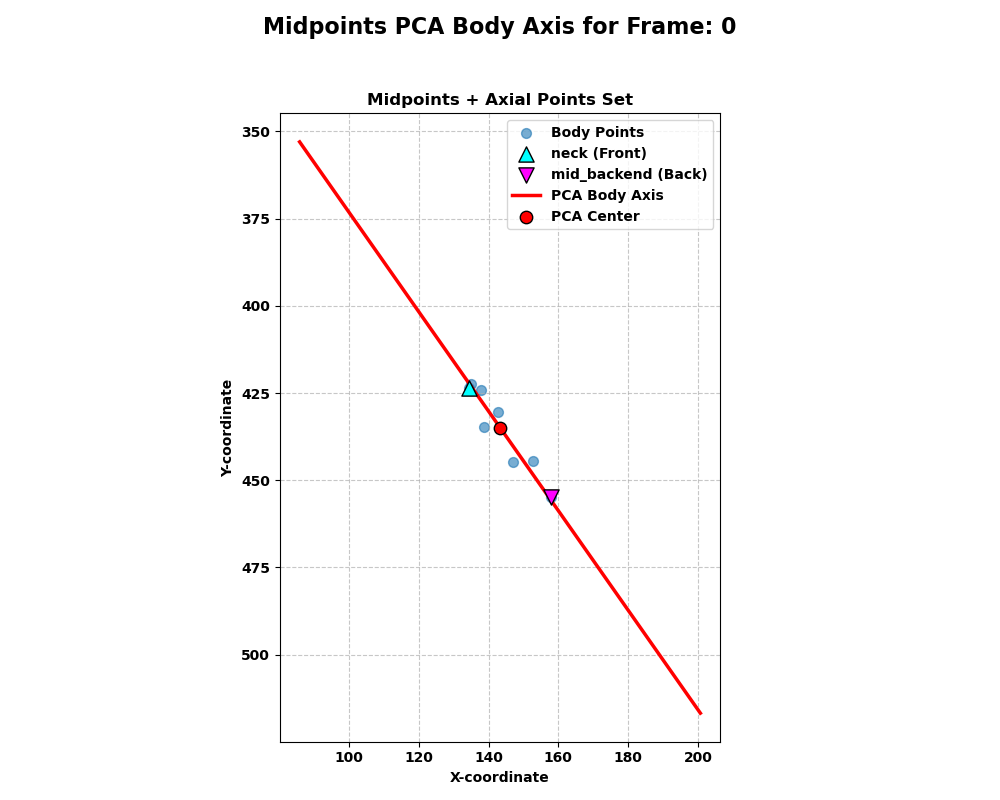

Saved midpoints PCA axis plot to: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_midpoints_pca_axis_frame_36124.png


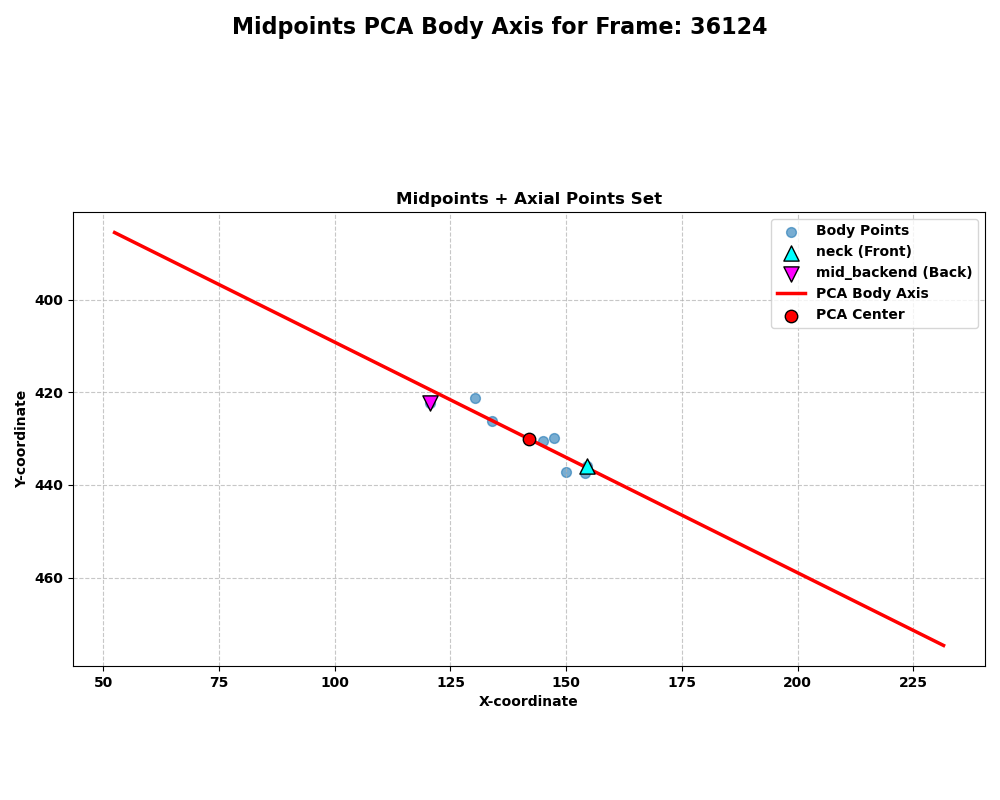

Saved midpoints PCA axis plot to: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_midpoints_pca_axis_frame_72249.png


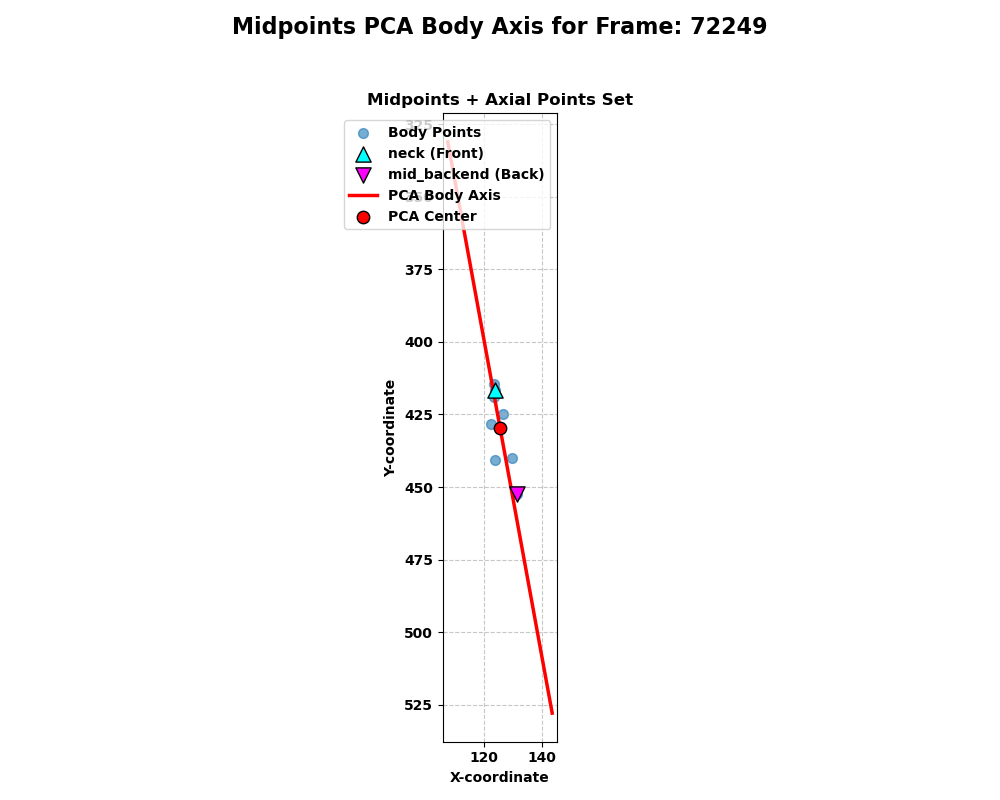

Saved midpoints PCA axis plot to: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_midpoints_pca_axis_frame_108374.png


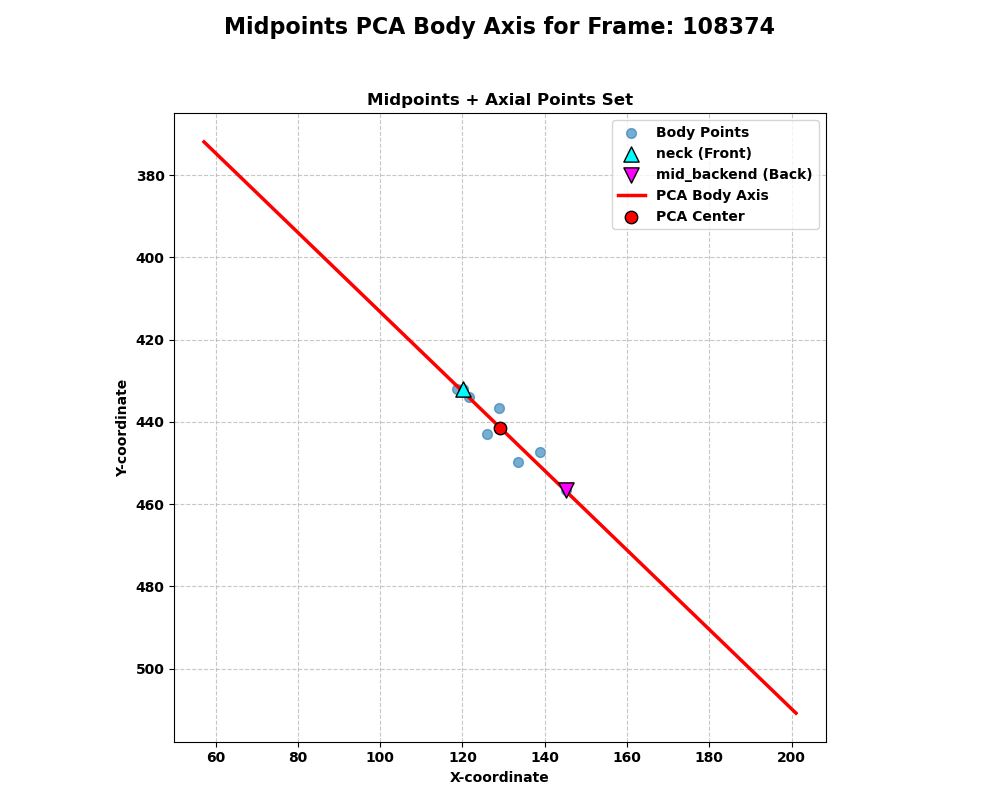

Saved midpoints PCA axis plot to: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_midpoints_pca_axis_frame_144499.png


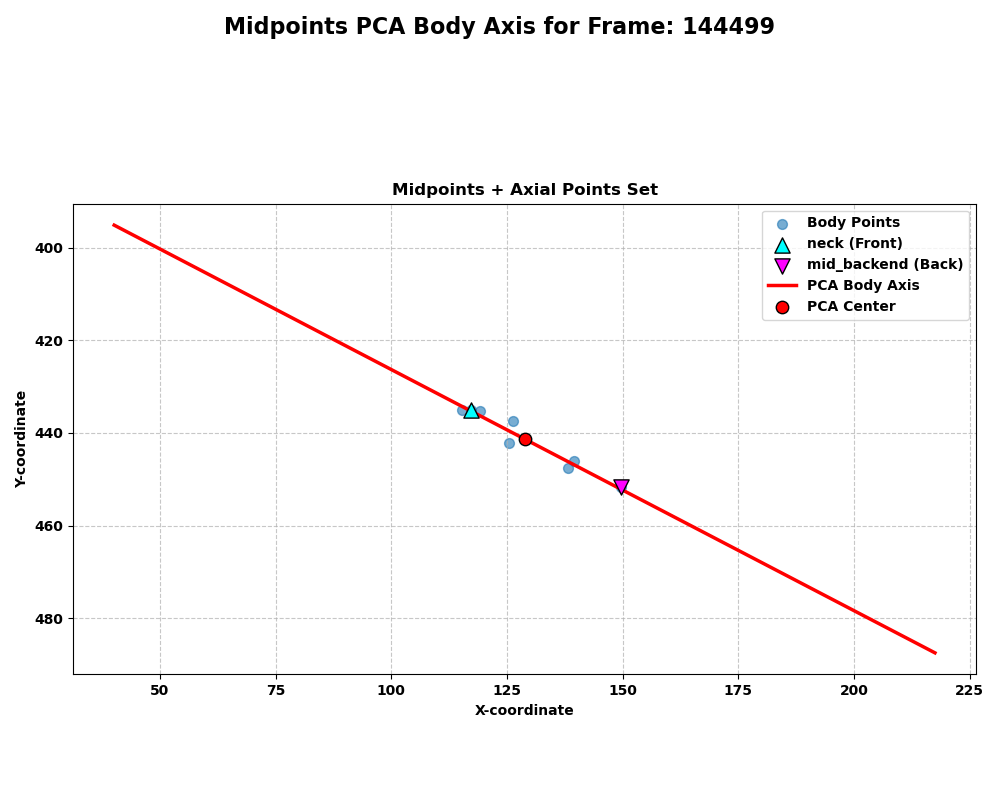

In [21]:
num_sample_frames = 5 # How many sample frames to plot
# Select some frames (e.g., start, middle, end of available frames)
total_frames = len(df_dlc.index)

# Ensure the required dataframes exist
required_dfs = ['df_midpoints_pca_raw', 'bodypart_coordinate_sets', 'df_dlc']
for req_df_name in required_dfs:
    if req_df_name not in globals():
        raise NameError(f"Required DataFrame '{req_df_name}' not found. Please ensure previous cells have been run.")

if 'output_dir_path' not in globals() or 'base_output_name' not in globals():
    raise NameError("Variables 'output_dir_path' or 'base_output_name' not found. Ensure cell 'd3f3a5c2' has run.")

# Ensure save_plots is defined, defaulting to False if not
if 'save_plots' not in globals():
    print("Warning: 'save_plots' variable not found. Defaulting to False for this cell.")
    save_plots_this_cell = False
else:
    save_plots_this_cell = save_plots

if total_frames == 0:
    print("Error: df_dlc has no frames. Cannot plot sample frames.")
else:
    sample_frame_indices = np.linspace(0, total_frames - 1, num_sample_frames, dtype=int)
    sample_frames = [df_dlc.index[i] for i in sample_frame_indices]

    print(f"\n--- Plotting Midpoints PCA Body Axis for Sample Frames: {sample_frames} ---")

    ref_point_front_name = 'neck'
    ref_point_back_name = 'mid_backend'

    for frame_idx in sample_frames:
        fig, ax = plt.subplots(figsize=(10, 8))
        fig.suptitle(f"Midpoints PCA Body Axis for Frame: {frame_idx}", fontsize=16)

        # Use only the "axial_plus_midpoints" set
        coords_dfs = bodypart_coordinate_sets["axial_plus_midpoints"]
        current_x_df = coords_dfs['x']
        current_y_df = coords_dfs['y']

        ax.set_title("Midpoints + Axial Points Set")
        ax.set_xlabel("X-coordinate")
        ax.set_ylabel("Y-coordinate")
        ax.invert_yaxis()  # DLC coordinates typically have origin at top-left
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, linestyle='--', alpha=0.7)

        if frame_idx not in current_x_df.index or frame_idx not in current_y_df.index:
            ax.text(0.5, 0.5, "Frame data not in index", ha='center', va='center', transform=ax.transAxes)
            continue

        x_coords_frame_series = current_x_df.loc[frame_idx].dropna()
        y_coords_frame_series = current_y_df.loc[frame_idx].dropna()
        
        common_index = x_coords_frame_series.index.intersection(y_coords_frame_series.index)
        x_coords_frame = x_coords_frame_series[common_index]
        y_coords_frame = y_coords_frame_series[common_index]

        if not x_coords_frame.empty:
            # Plot body points
            ax.scatter(x_coords_frame, y_coords_frame, label='Body Points', alpha=0.6, s=50)

            # Highlight reference points
            if ref_point_front_name in x_coords_frame.index:
                ax.scatter(x_coords_frame[ref_point_front_name], y_coords_frame[ref_point_front_name],
                           color='cyan', s=120, label=f'{ref_point_front_name} (Front)', 
                           edgecolors='black', zorder=5, marker='^')
            if ref_point_back_name in x_coords_frame.index:
                ax.scatter(x_coords_frame[ref_point_back_name], y_coords_frame[ref_point_back_name],
                           color='magenta', s=120, label=f'{ref_point_back_name} (Back)', 
                           edgecolors='black', zorder=5, marker='v')

            # Plot PCA Line for midpoints set
            if frame_idx in df_midpoints_pca_raw.index:
                pca_params = df_midpoints_pca_raw.loc[frame_idx]
                if not pca_params.isna().any():
                    pca_dx, pca_dy = pca_params['pca_dx'], pca_params['pca_dy']
                    pca_mean_x, pca_mean_y = pca_params['pca_mean_x'], pca_params['pca_mean_y']
                    
                    line_len = 100  # Make line longer for better visibility
                    x_pca = np.array([pca_mean_x - line_len * pca_dx, pca_mean_x + line_len * pca_dx])
                    y_pca = np.array([pca_mean_y - line_len * pca_dy, pca_mean_y + line_len * pca_dy])
                    ax.plot(x_pca, y_pca, color='red', linestyle='-', linewidth=2.5, 
                            label='PCA Body Axis', zorder=3)
                    ax.scatter(pca_mean_x, pca_mean_y, color='red', s=80, 
                               edgecolor='black', zorder=4, label='PCA Center')
        else:
            ax.text(0.5, 0.5, "No valid points for this frame", ha='center', va='center', transform=ax.transAxes)
        
        ax.legend(loc='upper right', fontsize='medium')
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        if save_plots_this_cell:
            plot_filename = os.path.join(output_dir_path, f"{base_output_name}_midpoints_pca_axis_frame_{frame_idx}.png")
            try:
                plt.savefig(plot_filename, dpi=300)
                print(f"Saved midpoints PCA axis plot to: {plot_filename}")
            except Exception as e:
                print(f"Error saving midpoints PCA axis plot for frame {frame_idx}: {e}")
        
        plt.show()

if total_frames == 0:
    print("Plotting skipped as df_dlc is empty.")

Extracts some frames to plot the lines of PCA/OLS onto the animal for quality check. Keep either in main as quality check or move to helper scripts for testing

Video file opened successfully: C:\Users\Experiment\Projects\video_conversions\full\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_labeled.mp4 (144500 frames)

--- Plotting Midpoints PCA Body Axis on Video Frames: [52179, 105101, 114646, 117837, 130405] ---
Saved midpoints PCA on frame plot: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_midpoints_pca_on_frame_52179.png


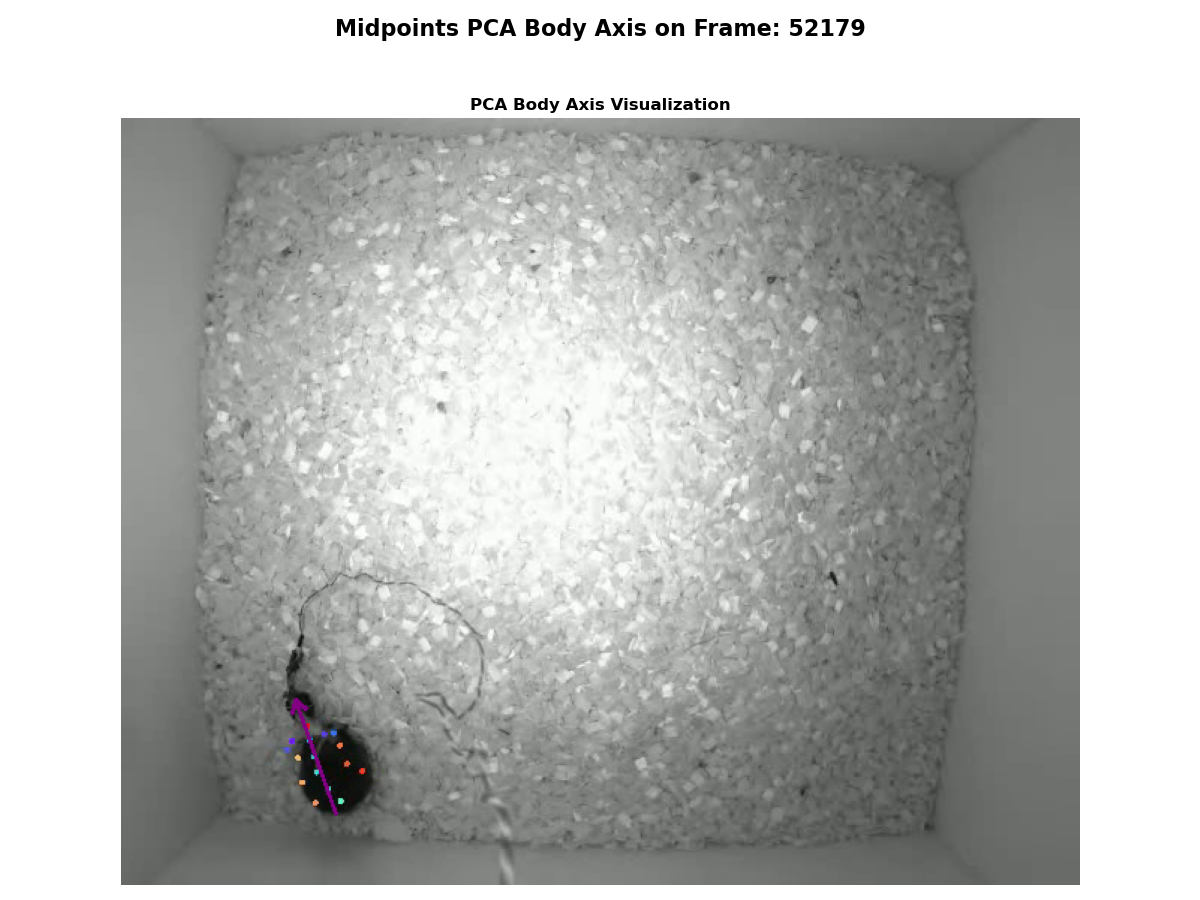

Saved midpoints PCA on frame plot: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_midpoints_pca_on_frame_105101.png


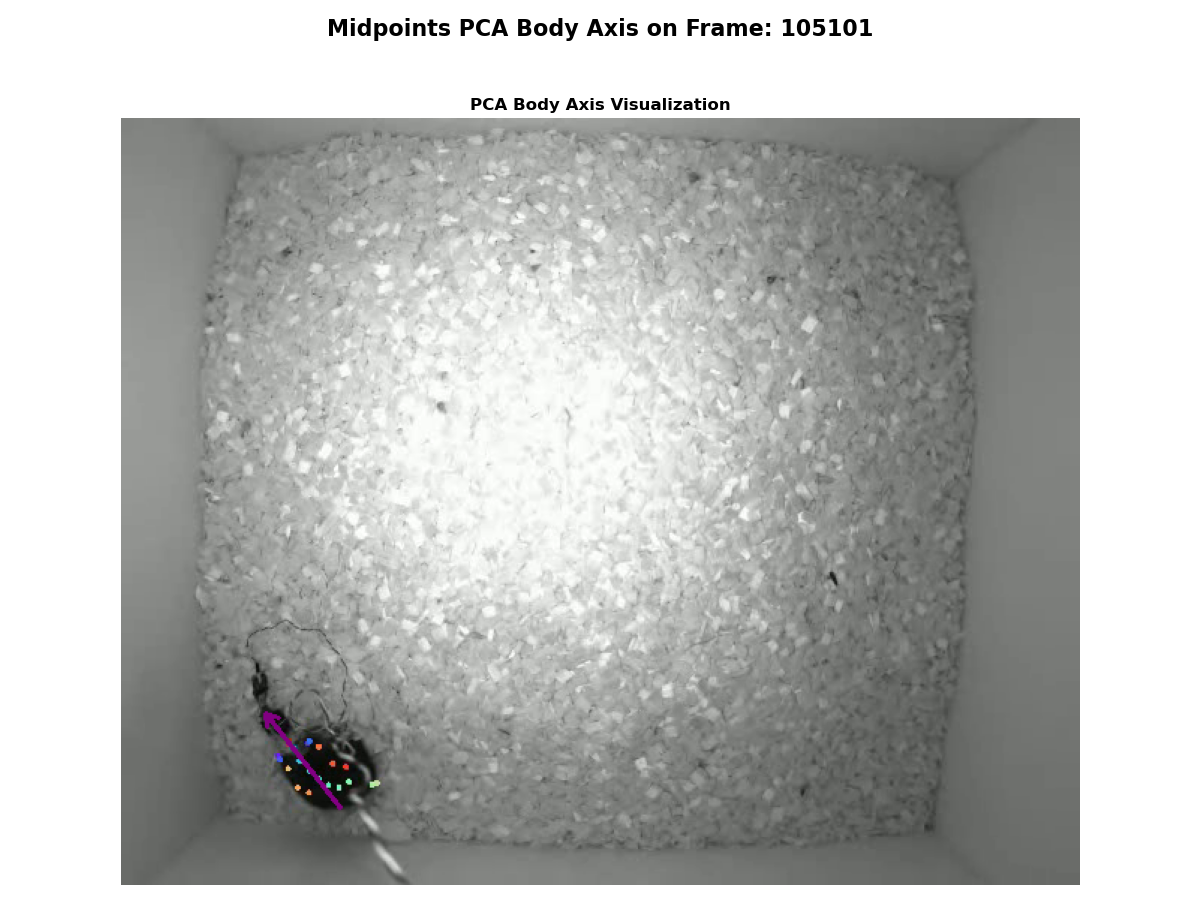

Saved midpoints PCA on frame plot: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_midpoints_pca_on_frame_114646.png


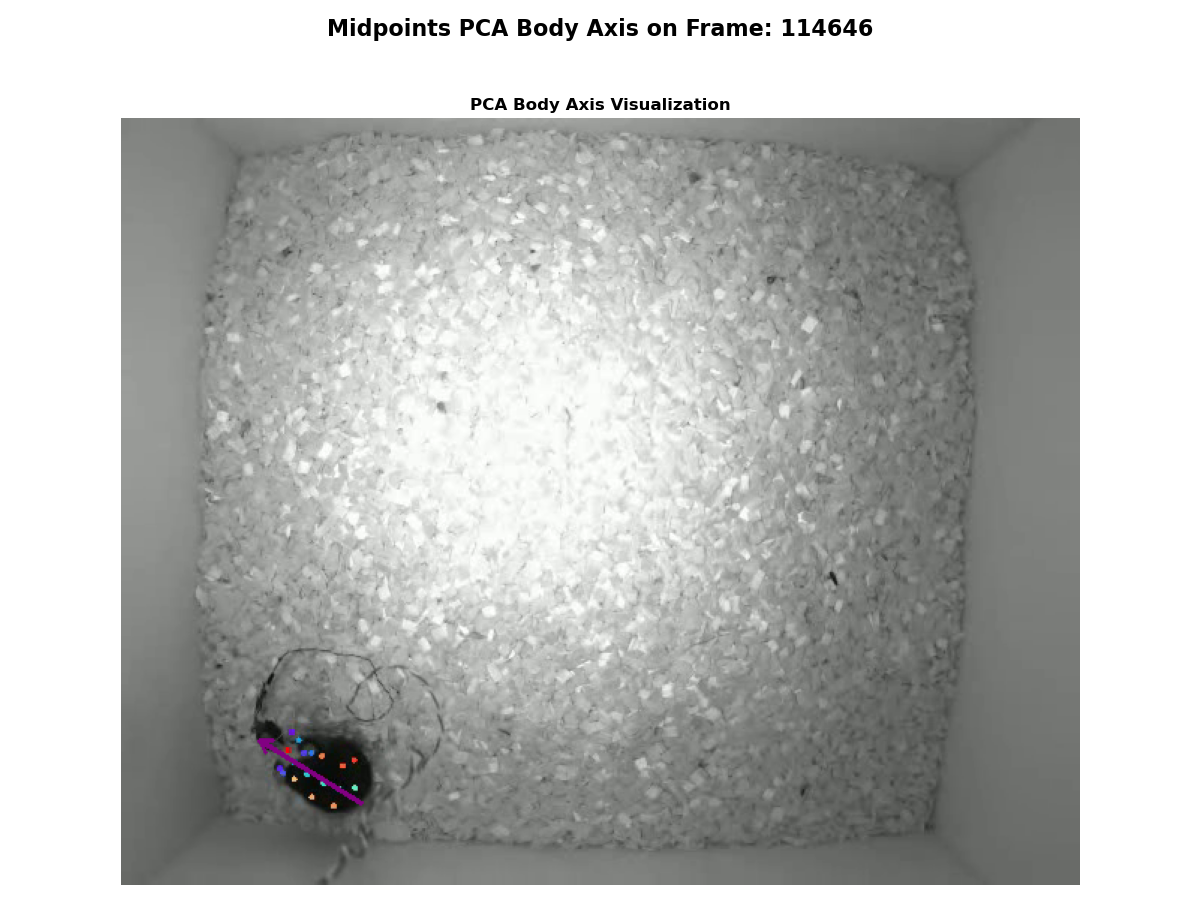

Saved midpoints PCA on frame plot: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_midpoints_pca_on_frame_117837.png


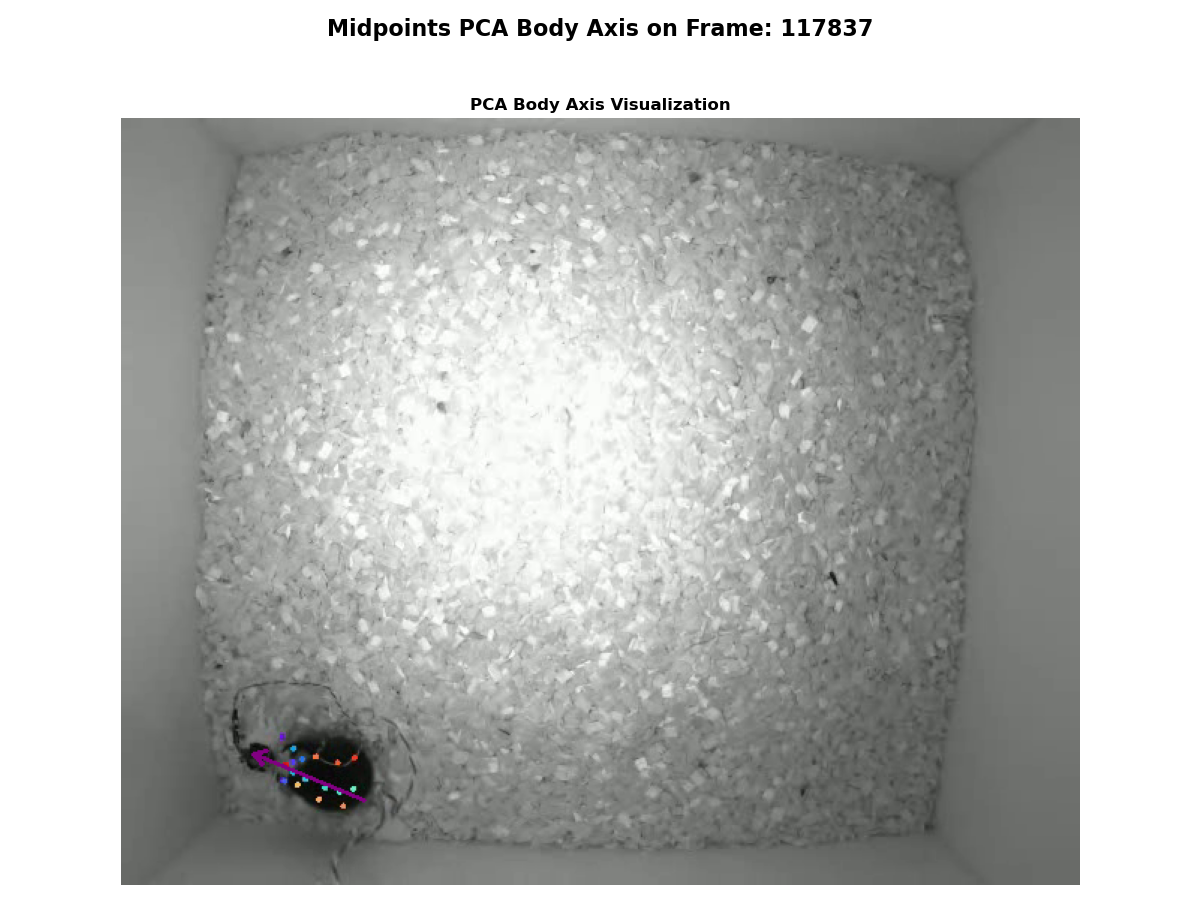

Saved midpoints PCA on frame plot: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_midpoints_pca_on_frame_130405.png


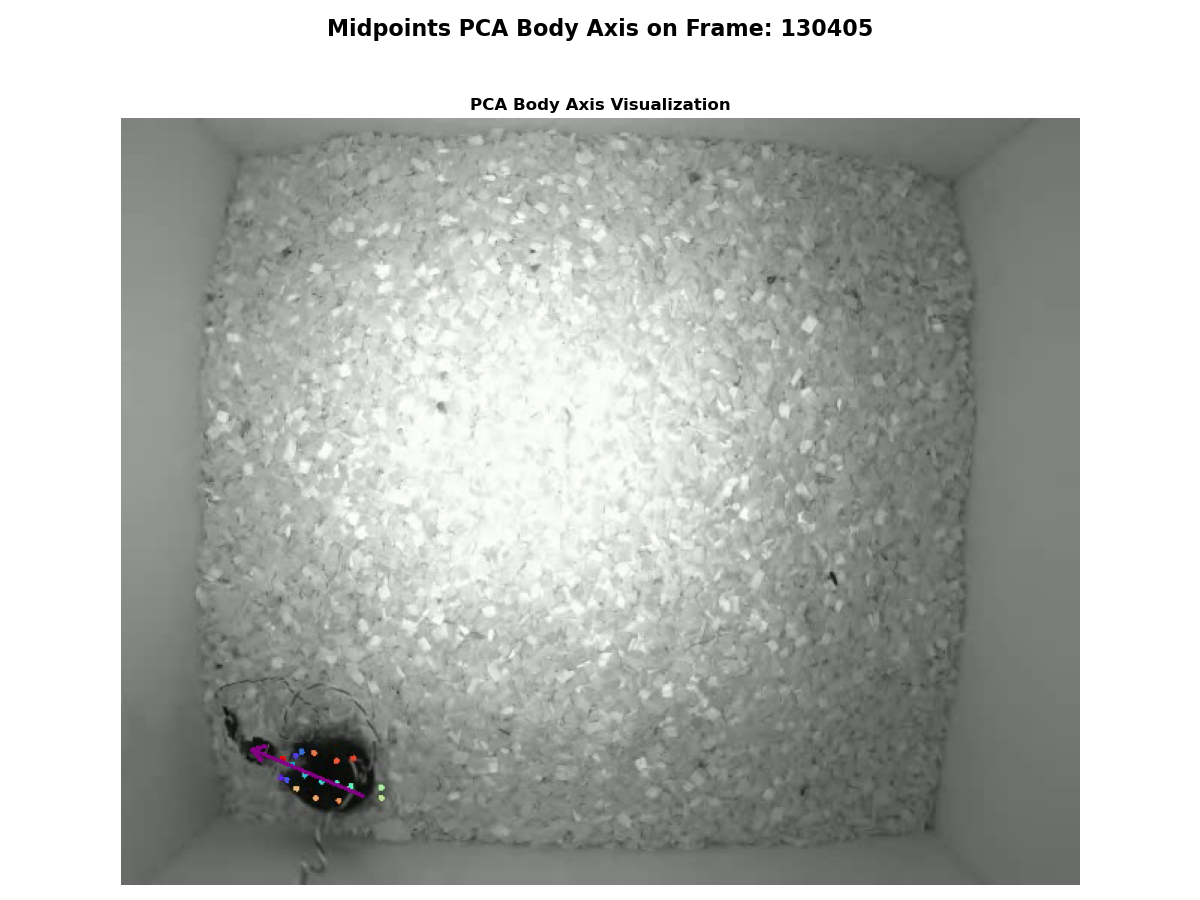

In [25]:
num_sample_frames = 5 # How many sample frames to plot
total_frames_in_df = len(df_dlc.index) 

# Ensure the required dataframes exist
required_dfs = ['df_midpoints_pca_raw', 'bodypart_coordinate_sets', 'df_dlc']
for req_df_name in required_dfs:
    if req_df_name not in globals():
        raise NameError(f"Required DataFrame '{req_df_name}' not found. Please ensure previous cells have been run.")

if 'video_file_path' not in globals() or not os.path.exists(video_file_path):
    print("Warning: Video file path not found or video file does not exist. Skipping frame overlay plotting.")
else:
    cap = cv2.VideoCapture(video_file_path)
    if cap.isOpened():
        video_total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"Video file opened successfully: {video_file_path} ({video_total_frames} frames)")
        
        # Select random frames that exist in both the DataFrame and video
        valid_frame_indices = [i for i in range(min(total_frames_in_df, video_total_frames))]
        sample_frames_to_plot = sorted(np.random.choice(valid_frame_indices, 
                                               size=min(num_sample_frames, len(valid_frame_indices)), 
                                               replace=False))
        
        print(f"\n--- Plotting Midpoints PCA Body Axis on Video Frames: {sample_frames_to_plot} ---")
        
        # Define color for the PCA line (purple in BGR)
        color_pca_line = (130, 0, 130)

        for frame_idx_to_plot in sample_frames_to_plot:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx_to_plot)
            ret, frame_bgr = cap.read()
            if not ret:
                print(f"Warning: Could not read frame {frame_idx_to_plot} from video.")
                continue

            fig, ax = plt.subplots(figsize=(12, 9))
            fig.suptitle(f"Midpoints PCA Body Axis on Frame: {frame_idx_to_plot}", fontsize=16)
            
            ax.set_title("PCA Body Axis Visualization")
            ax.axis('off')  # Turn off axis numbers and ticks for image display

            frame_to_draw_on = frame_bgr.copy()

            # Get the "axial_plus_midpoints" data for the current frame
            coords_dfs = bodypart_coordinate_sets["axial_plus_midpoints"]
            current_x_df = coords_dfs['x']
            current_y_df = coords_dfs['y']

            x_coords_frame = current_x_df.loc[frame_idx_to_plot].dropna()
            y_coords_frame = current_y_df.loc[frame_idx_to_plot].dropna()
            
            common_index = x_coords_frame.index.intersection(y_coords_frame.index)
            
            # Plot PCA Line from midpoints_pca data
            pca_params = df_midpoints_pca_raw.loc[frame_idx_to_plot]
            if not pca_params.isna().any():
                pca_dx, pca_dy = pca_params['pca_dx'], pca_params['pca_dy']
                pca_mean_x, pca_mean_y = pca_params['pca_mean_x'], pca_params['pca_mean_y']
                
                # Make line shorter (50 units)
                line_len = 40
                
                # Check for anatomical orientation to determine arrow direction
                front_bp_name = 'neck'
                back_bp_name = 'mid_backend'
                
                if (front_bp_name in common_index and back_bp_name in common_index):
                    f_x, f_y = x_coords_frame[front_bp_name], y_coords_frame[front_bp_name]
                    b_x, b_y = x_coords_frame[back_bp_name], y_coords_frame[back_bp_name]
                    
                    # Calculate anatomical direction vector
                    anat_dx, anat_dy = f_x - b_x, f_y - b_y
                    
                    # Check if PCA direction needs to be flipped to match anatomical direction
                    if (pca_dx * anat_dx + pca_dy * anat_dy) < 0:
                        pca_dx, pca_dy = -pca_dx, -pca_dy
                
                # Calculate the line endpoints
                x1 = int(pca_mean_x - line_len * pca_dx)
                y1 = int(pca_mean_y - line_len * pca_dy)
                x2 = int(pca_mean_x + line_len * pca_dx)
                y2 = int(pca_mean_y + line_len * pca_dy)
                
                # Draw the thin purple line
                cv2.line(frame_to_draw_on, (x1, y1), (x2, y2), color_pca_line, 2)
                
                # Draw arrowhead at the "front" end of the line
                arrow_size = 10
                arrow_angle = np.arctan2(y2 - y1, x2 - x1)
                arrow_x1 = int(x2 - arrow_size * np.cos(arrow_angle - np.pi/6))
                arrow_y1 = int(y2 - arrow_size * np.sin(arrow_angle - np.pi/6))
                arrow_x2 = int(x2 - arrow_size * np.cos(arrow_angle + np.pi/6))
                arrow_y2 = int(y2 - arrow_size * np.sin(arrow_angle + np.pi/6))
                
                # Draw the arrowhead lines
                cv2.line(frame_to_draw_on, (x2, y2), (arrow_x1, arrow_y1), color_pca_line, 2)
                cv2.line(frame_to_draw_on, (x2, y2), (arrow_x2, arrow_y2), color_pca_line, 2)
            
            # Convert to RGB for matplotlib display
            frame_rgb_display = cv2.cvtColor(frame_to_draw_on, cv2.COLOR_BGR2RGB)
            ax.imshow(frame_rgb_display)
        
            plt.tight_layout(rect=[0, 0, 1, 0.95]) 

            if save_plots:
                plot_filename = os.path.join(output_dir_path, f"{base_output_name}_midpoints_pca_on_frame_{frame_idx_to_plot}.png")
                try:
                    plt.savefig(plot_filename, dpi=150)
                    print(f"Saved midpoints PCA on frame plot: {plot_filename}")
                except Exception as e:
                    print(f"Error saving midpoints PCA on frame plot for frame {frame_idx_to_plot}: {e}")
        
            plt.show()

        cap.release()


# Debugging


### Debugging for the median 

Plot X Y trajectories for all selected body parts to see how stable they are over time. 

In [ ]:
if 'create_plots' in globals() and create_plots:
    if all(var in globals() for var in ['df_dlc', 'final_bodyparts_list', 'likelihood_threshold', 'output_dir_path', 'base_output_name', 'save_plots']):
        print("\n--- Generating X-Y Trajectory Plots ---")
        plot_bodypart_and_median_trajectories(
            df_dlc=df_dlc,
            final_bodyparts_list=final_bodyparts_list,
            likelihood_threshold=likelihood_threshold,
            output_dir_path=output_dir_path,
            plot_file_base_name=base_output_name, 
            save_plot=False,
            display_plot=True # Show plot in notebook
        )
    else:
        print("\nSkipping X-Y trajectory plot: One or more required variables are not defined.")
        print("Required: df_dlc, final_bodyparts_list, likelihood_threshold, output_dir_path, base_output_name, save_plots")
else:
    print("\nSkipping X-Y trajectory plot: 'create_plots' is False or not defined.")


### Debugging: Plot Histogramm of consecutive NaNs in any bodypart after likelihood threshold filtering

In [ ]:
if 'create_plots' in globals() and globals().get('create_plots'):
    if all(var in globals() for var in ['df_dlc', 'final_bodyparts_list', 'likelihood_threshold', 'output_dir_path', 'base_output_name', 'save_plots']):
        print("\n--- Generating Consecutive NaN Length Plots ---")
        plot_consecutive_nan_lengths(
            df_dlc=df_dlc,
            final_bodyparts_list=final_bodyparts_list,
            likelihood_threshold=likelihood_threshold,
            output_dir_path=output_dir_path,
            plot_file_base_name=base_output_name,
            save_plot=globals().get('save_plots', False), # Use globals().get for safety
            display_plot=True
        )
    else:
        print("\nSkipping Consecutive NaN Length Plots: One or more required variables are not defined in globals().")
        required_vars_check = ['df_dlc', 'final_bodyparts_list', 'likelihood_threshold', 'output_dir_path', 'base_output_name', 'save_plots']
        for v in required_vars_check:
            if v not in globals():
                print(f"Missing: {v}")
else:
    if 'create_plots' not in globals():
        print("\nSkipping Consecutive NaN Length Plots: 'create_plots' is not defined in globals().")
    elif not globals().get('create_plots'):
        print("\nSkipping Consecutive NaN Length Plots: 'create_plots' is False.")
